<div style="display: flex; align-items: center;">
    <img alt="udeA logo" height="140px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" style="width:107px;height:152px; margin-right: 40px;">
    <div style="text-align: center;">
        <h1><b><font color='0B5345'>Proyecto 3: Filtros</font></b></h1>
        <h2><font color='0B5345'>Proyecto 2024-02</font></h2>
        <h3><font color='0B5345'>Luisa Fernanda Enciso - Jader Chingal</font></h3>
    </div>
</div>

In [3]:
import pandas as pd
import seaborn as sns
import scipy.signal as signal
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random
from scipy.signal import butter, filtfilt
import pywt
from scipy.signal import detrend
import warnings
from scipy.signal import welch
from sklearn.metrics import mean_squared_error
from skimage.restoration import denoise_nl_means, estimate_sigma
from scipy.signal import savgol_filter
from statsmodels.nonparametric.smoothers_lowess import lowess
warnings.filterwarnings('ignore')


<hr>

Consultar y explicar los dos métodos de reducción de ruido usados en el artículo: Robust LOESS y Non Local Means (10%), mostrar cómo se podrían implementar en Python (5%)

* Robust LOESS (Locally Estimated Scatterplot Smoothing)

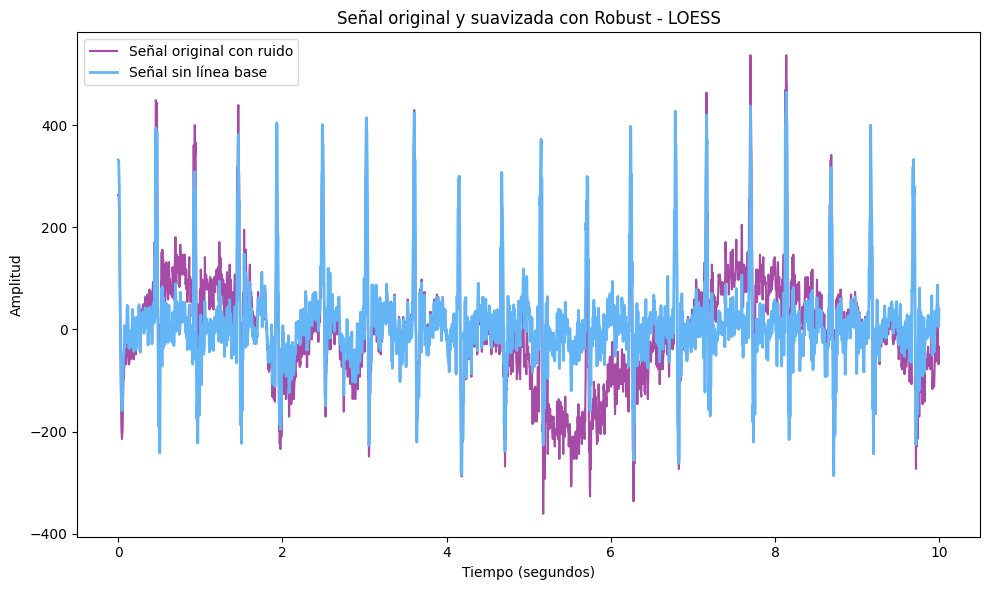

In [4]:
# Ruta donde están los archivos
ruta_senales = r"C:\Users\luisa\Downloads\ECGData\ECGData"

# Nombre del archivo a procesar
nombre_archivo ='MUSE_20180113_171327_27000.csv'
# Cargar el archivo CSV
ruta_archivo = os.path.join(ruta_senales, nombre_archivo)
df = pd.read_csv(ruta_archivo)

# Asegurarse de que las columnas esperadas estén presentes
columnas = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
if 'II' not in df.columns:
    raise ValueError("La columna 'II' no se encuentra en el archivo CSV")

# Extraer la derivación II (la señal original)
LPassDataFile = df['II'].values

# Paso 1: Suavizado robusto Loess utilizando statsmodels
# Se usa el suavizado Lowess con un enfoque robusto
frac = 0.1  # Fracción de los datos utilizados en cada estimación local
it = 3  # Número de iteraciones para robustez

# Aplicar el suavizado robusto Loess
smoothed_signal = lowess(LPassDataFile, np.arange(len(LPassDataFile)), frac=frac, it=it)

# smoothed_signal[:, 1] contiene la señal suavizada
smoothed_signal = smoothed_signal[:, 1]

# Paso 2: Eliminar la componente de baja frecuencia (linea base)
BWRemoveDataFile = LPassDataFile - smoothed_signal  # Señal sin la línea base

# Graficar resultados
plt.figure(figsize=(10, 6))

# Señal original con ruido y señal suavizada con robust Loess (sin la línea base)
t = np.arange(len(LPassDataFile)) / 500  # Tiempo en segundos, fs=500
plt.plot(t, LPassDataFile, label="Señal original con ruido", color='purple', alpha=0.7)

plt.plot(t, BWRemoveDataFile, label="Señal sin línea base", color='#64B5F6', linewidth=2)
plt.title("Señal original y suavizada con Robust - LOESS")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Amplitud")
plt.legend()

plt.tight_layout()
plt.show()


* Non-Local Means (NLM)


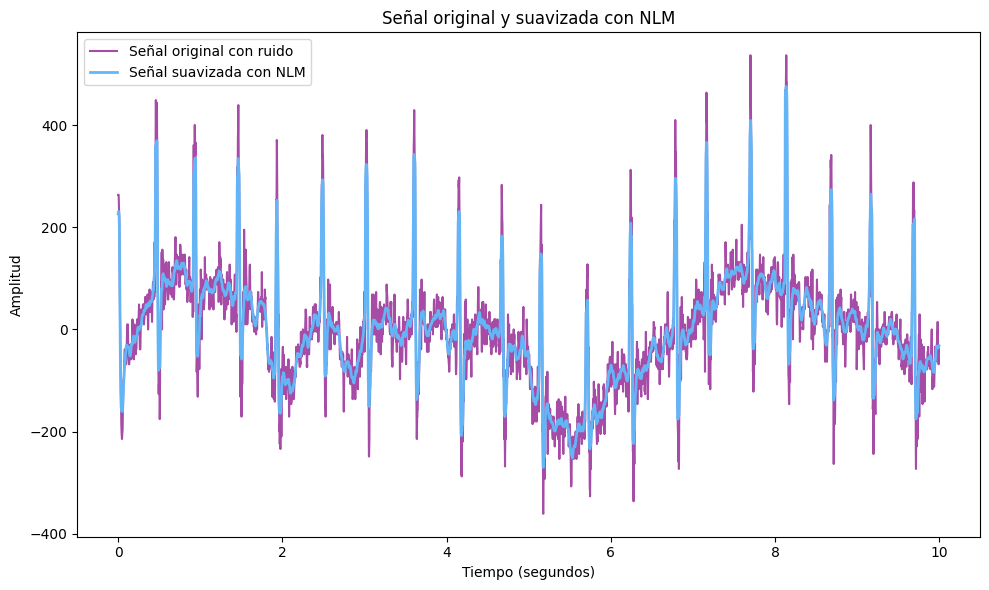

In [5]:
# Ruta donde están los archivos
ruta_senales = r"C:\Users\luisa\Downloads\ECGData\ECGData"

# Nombre del archivo a procesar
nombre_archivo='MUSE_20180113_171327_27000.csv'
# Cargar el archivo CSV
ruta_archivo = os.path.join(ruta_senales, nombre_archivo)
df = pd.read_csv(ruta_archivo)

# Asegurarse de que las columnas esperadas estén presentes
columnas = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
if 'II' not in df.columns:
    raise ValueError("La columna 'II' no se encuentra en el archivo CSV")

# Extraer la derivación II (la señal original)
LPassDataFile = df['II'].values

# Paso 1: Estimación de la desviación estándar del ruido
NoisSTD = 1.4826 * np.median(np.abs(LPassDataFile - np.median(LPassDataFile)))

# Paso 2: Convertir la señal a 2D para aplicar NLM
LPassDataFile_2d = LPassDataFile.reshape(1, -1)

# Paso 3: Aplicación de Non-Local Means (NLM)
denoised_signal_2d = denoise_nl_means(
    LPassDataFile_2d,
    h=(1.5 * NoisSTD),  # Factor de ruido
    patch_size=5,
    patch_distance=10,
    fast_mode=True
)

# Convertir el resultado de 2D a 1D
denoised_signal = denoised_signal_2d.ravel()

# Graficar resultados
t = np.arange(len(LPassDataFile)) / 500  # Tiempo en segundos, fs=500

plt.figure(figsize=(10, 6))

# Señal original con ruido y señal suavizada con NLM
plt.plot(t, LPassDataFile, label="Señal original con ruido", color='purple', alpha=0.7)
plt.plot(t, denoised_signal, label="Señal suavizada con NLM", color='#64B5F6', linewidth=2)
plt.title("Señal original y suavizada con NLM")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Amplitud")
plt.legend()

plt.tight_layout()
plt.show()


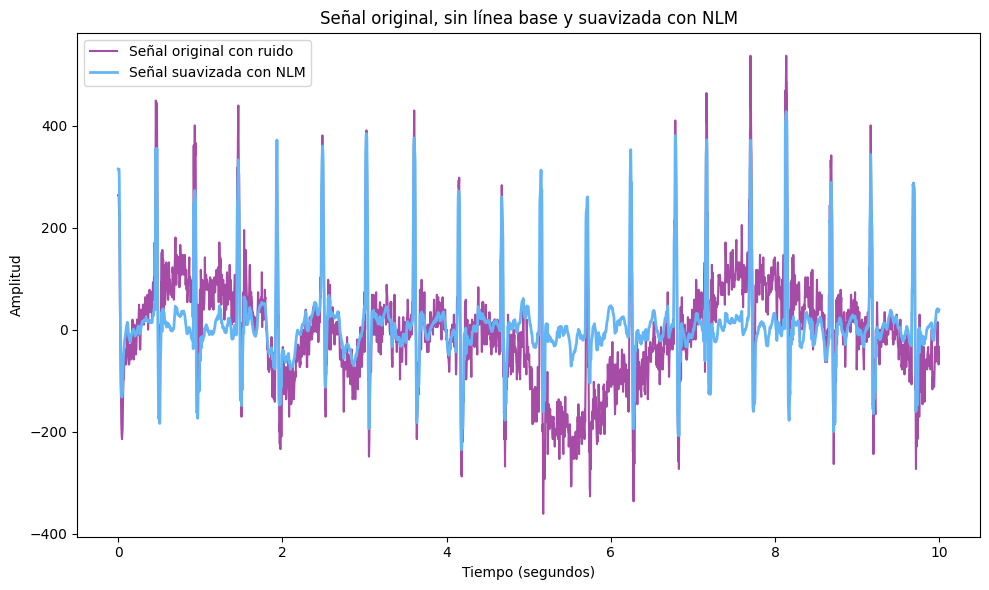

In [6]:
# Paso 1: Suavizado robusto Loess para eliminar la línea base
frac = 0.1  # Fracción de los datos utilizados en cada estimación local
it = 3  # Número de iteraciones para robustez
smoothed_signal = lowess(LPassDataFile, np.arange(len(LPassDataFile)), frac=frac, it=it)
smoothed_signal = smoothed_signal[:, 1]  # Solo la señal suavizada

# Paso 2: Eliminar la línea base (componente de baja frecuencia)
BWRemoveDataFile = LPassDataFile - smoothed_signal  # Señal sin línea base

# Paso 3: Estimación de la desviación estándar del ruido
NoisSTD = 1.4826 * np.median(np.abs(BWRemoveDataFile - np.median(BWRemoveDataFile)))

# Paso 4: Convertir la señal a 2D para aplicar NLM
BWRemoveDataFile_2d = BWRemoveDataFile.reshape(1, -1)

# Paso 5: Aplicación de Non-Local Means (NLM)
denoised_signal_2d = denoise_nl_means(
    BWRemoveDataFile_2d,
    h=(1.5 * NoisSTD),  # Factor de ruido
    patch_size=5,
    patch_distance=10,
    fast_mode=True
)

# Convertir el resultado de 2D a 1D
denoised_signal = denoised_signal_2d.ravel()

# Graficar resultados
t = np.arange(len(LPassDataFile)) / 500  # Tiempo en segundos, fs=500

plt.figure(figsize=(10, 6))

# Señal original con ruido, la señal sin la línea base y la señal denoised
plt.plot(t, LPassDataFile, label="Señal original con ruido", color='purple', alpha=0.7)
plt.plot(t, denoised_signal, label="Señal suavizada con NLM", color='#64B5F6', linewidth=2)
plt.title("Señal original, sin línea base y suavizada con NLM")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Amplitud")
plt.legend()

plt.tight_layout()
plt.show()

<hr>

Extracción de los registros que corresponden a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). 

In [7]:
# Cargar el archivo Excel en un DataFrame
ruta=r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto2\Diagnostics.xlsx"
diagnostics_df = pd.read_excel(ruta)

# Crear el nuevo dataframe filtrando por la columna 'Rhythm'
datos = diagnostics_df[(diagnostics_df['Rhythm'] == 'SB') | (diagnostics_df['Rhythm'] == 'AFIB')]

# Discriminar datos de acuerdo a su caracteristica 
datos_SB = diagnostics_df[(diagnostics_df['Rhythm'] == 'SB')]
datos_AFIB = diagnostics_df[(diagnostics_df['Rhythm'] == 'AFIB')]

# Convertir la columna 'FileName' en una lista de Python
datos_lista = datos['FileName'].tolist()

datos_lista_SB = datos_SB['FileName'].tolist()
datos_lista_AFIB = datos_AFIB['FileName'].tolist()

datos.head()

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
5,MUSE_20180112_120347_79000,SB,NONE,46,FEMALE,57,57,70,404,393,38,24,9,225,260,427
6,MUSE_20180114_075026_69000,AFIB,TWC,80,FEMALE,98,86,74,360,459,69,83,17,215,252,395


In [8]:
# Imprimir los tamaños de las listas
print(f"Tamaño total de Datos (SB + AFIB): {len(datos_lista)}")
print(f"Tamaño de (SB): {len(datos_lista_SB)}")
print(f"Tamaño de (AFIB): {len(datos_lista_AFIB)}")

Tamaño total de Datos (SB + AFIB): 5669
Tamaño de (SB): 3889
Tamaño de (AFIB): 1780


<hr>

Consultar que otros tipos de señales wavelet se pueden usar para el análisis de señales ECG y adaptar el código del filtro wavelet que se entrega en el curso de acuerdo a la consulta (10%)

In [ ]:
def filtro_wavelet(signal_data, wavelet='dB4', nivel=4):
    coeffs = pywt.wavedec(signal_data, wavelet, level=nivel)
    umbral = np.median(np.abs(coeffs[-1])) / 0.6745
    coeffs = [pywt.threshold(c, umbral, mode='soft') for c in coeffs]
    return pywt.waverec(coeffs, wavelet)

<hr>

Escoger 10 señales al azar

In [10]:
# Definir la ruta del archivo donde se guardarán los nombres de archivo seleccionados
archivo_seleccion = r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto3\seleccion_filename.txt"

# Comprobar si el archivo de selección ya existe
if os.path.exists(archivo_seleccion):
    # Cargar los nombres de archivo previamente guardados
    with open(archivo_seleccion, "r") as f:
        seleccion = f.read().splitlines()
    seleccion_SB = seleccion[:5]
    seleccion_AFIB = seleccion[5:]
else:
    # Si el archivo no existe, realizar una selección aleatoria y guardarla
    seleccion_SB = random.sample(datos_SB['FileName'].tolist(), 5)
    seleccion_AFIB = random.sample(datos_AFIB['FileName'].tolist(), 5)
    
    # Guardar solo los nombres de archivo en el archivo de texto
    with open(archivo_seleccion, "w") as f:
        for filename in seleccion_SB + seleccion_AFIB:
            f.write(f"{filename}\n")

# Imprimir las selecciones
print("Señales seleccionadas de SB:", seleccion_SB)
print("Señales seleccionadas de AFIB:", seleccion_AFIB)

Señales seleccionadas de SB: ['MUSE_20180114_070658_51000', 'MUSE_20180113_122021_63000', 'MUSE_20180113_184550_73000', 'MUSE_20180113_184711_55000', 'MUSE_20180118_180721_94000']
Señales seleccionadas de AFIB: ['MUSE_20180116_121956_37000', 'MUSE_20180115_125217_32000', 'MUSE_20180119_171120_09000', 'MUSE_20180113_135045_85000', 'MUSE_20180113_074547_62000']


<hr>

Datos generales

In [11]:
# Ruta donde están almacenados los archivos .csv
ruta_senales = r"C:\Users\luisa\Downloads\ECGData\ECGData"
ruta_senales_prefiltradas = r"C:\Users\luisa\Downloads\ECGDataDenoised\ECGDataDenoised"
archivo_seleccion = r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto3\seleccion_filename.txt"

# Nombres de las columnas esperadas en los archivos CSV
columnas = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Configuración de la frecuencia de muestreo
fs = 500  # Frecuencia de muestreo en Hz 

<hr>

<h1>Flujo 1</h1>

1. Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros y si se usa FIR o IIR
2. Filtro wavelet modificado del punto 3
3. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

In [12]:
def filtro_pasa_altas_F1(signal_data, fs, cutoff=0.5, order=5):
    nyquist = 0.5 * fs
    wn_h = cutoff / nyquist
    b_high, a_high = signal.iirfilter(order, wn_h, rs=40, btype='high', analog=False, ftype='cheby2')
    filtered_signal = signal.filtfilt(b=b_high, a=a_high, x=signal_data)
    return filtered_signal

def filtro_pasa_bajas_F1(signal_data, fs, cutoff=50, order=250):
    nyquist = 0.5 * fs
    beta=14
    wn = cutoff / nyquist  
    lowpass = signal.firwin(order + 1, wn, pass_zero='lowpass', window=('kaiser', beta))  
    return signal.filtfilt(b=lowpass, a=1, x=signal_data)  

In [13]:
def procesar_flujo1(nombre_archivo, ruta_senales, columnas, fs):
    ruta_archivo = os.path.join(ruta_senales, nombre_archivo + ".csv")

    if os.path.exists(ruta_archivo):
        # Leer el archivo de señal y el archivo prefiltrado
        df = pd.read_csv(ruta_archivo, delimiter=',', names=columnas, header=0)
        signal = df['II'].to_numpy()  # Extraer derivación II

        # Aplicar filtros
        signal_filtro_pasa_altas = filtro_pasa_altas_F1(signal, fs)
        signal_filtro_wavelet = filtro_wavelet(signal_filtro_pasa_altas)
        signal_filtro_pasa_bajas = filtro_pasa_bajas_F1(signal_filtro_wavelet, fs)

        # La señal procesada final es signal_filtro_pasa_bajas
        señal_procesada = signal_filtro_pasa_bajas

        return signal, señal_procesada, nombre_archivo  # Retornar la señal original, procesada y el nombre
    else:
        print(f"El archivo {ruta_archivo} no existe.")
        return None


In [14]:
# Diccionario para almacenar cada señal procesada con nombres únicos
señales_procesadas_F1_SB = {}

# Procesar cada archivo en la selección
for i, nombre_archivo in enumerate(seleccion_SB):
    resultado = procesar_flujo1(nombre_archivo, ruta_senales, columnas, fs)
    if resultado is not None:
        señal_original, señal_procesada, nombre = resultado
        señales_procesadas_F1_SB[f'SB_Flujo1_S{i+1}'] = {
            'original': señal_original,
            'procesada': señal_procesada,
            'nombre_archivo': nombre
        }

print("Señales seleccionadas de SB:", señales_procesadas_F1_SB)

Señales seleccionadas de SB: {'SB_Flujo1_S1': {'original': array([-156.16,  -87.84,  -39.04, ...,   48.8 ,   58.56,   39.04]), 'procesada': array([-9.26753777, 32.0715059 , 71.72569639, ..., -2.17500501,
       -2.09404455, -1.8059033 ]), 'nombre_archivo': 'MUSE_20180114_070658_51000'}, 'SB_Flujo1_S2': {'original': array([-48.8 , -48.8 , -48.8 , ..., 112.24, 131.76, 117.12]), 'procesada': array([-19.72087032, -17.70807938, -16.34731864, ...,  11.09040656,
         7.66809904,   3.48862129]), 'nombre_archivo': 'MUSE_20180113_122021_63000'}, 'SB_Flujo1_S3': {'original': array([-48.8 , -53.68, -34.16, ..., -14.64, -29.28, -14.64]), 'procesada': array([-8.11630187, -0.75158272,  5.40137544, ..., 56.95269775,
       49.26073082, 41.1583212 ]), 'nombre_archivo': 'MUSE_20180113_184550_73000'}, 'SB_Flujo1_S4': {'original': array([122.  , 131.76, 151.28, ...,  73.2 ,  43.92,  58.56]), 'procesada': array([108.95488298, 112.53556634, 116.36346779, ...,  30.3754388 ,
        21.59632406,  11.90743

In [15]:
# Diccionario para almacenar cada señal procesada con nombres únicos
señales_procesadas_F1_AFIB = {}

# Procesar cada archivo en la selección
for i, nombre_archivo in enumerate(seleccion_AFIB):
    resultado = procesar_flujo1(nombre_archivo, ruta_senales, columnas, fs)
    if resultado is not None:
        señal_original, señal_procesada, nombre = resultado
        señales_procesadas_F1_AFIB[f'AFIB_Flujo1_S{i+1}'] = {
            'original': señal_original,
            'procesada': señal_procesada,
            'nombre_archivo': nombre
        }

print("Señales seleccionadas de AFIB:", señales_procesadas_F1_AFIB)

Señales seleccionadas de AFIB: {'AFIB_Flujo1_S1': {'original': array([-156.16, -156.16, -156.16, ...,  -29.28,  -39.04,  -39.04]), 'procesada': array([-29.18920786, -23.86384827, -19.11170596, ..., -17.22541823,
       -24.2763181 , -33.19628912]), 'nombre_archivo': 'MUSE_20180116_121956_37000'}, 'AFIB_Flujo1_S2': {'original': array([ 0.  ,  0.  ,  0.  , ..., 19.52, 29.28, 53.68]), 'procesada': array([  9.8886568 ,  10.0256265 ,  10.66959359, ..., -27.64986815,
       -19.50245302, -10.57989648]), 'nombre_archivo': 'MUSE_20180115_125217_32000'}, 'AFIB_Flujo1_S3': {'original': array([  19.52,   19.52,   19.52, ..., -195.2 , -224.48, -253.76]), 'procesada': array([ 18.26527269,  18.72558554,  19.64079273, ..., 321.70877799,
       311.46850176, 306.19471019]), 'nombre_archivo': 'MUSE_20180119_171120_09000'}, 'AFIB_Flujo1_S4': {'original': array([-122.  , -141.52, -131.76, ...,   53.68,   63.44,   48.8 ]), 'procesada': array([-10.78850954, -10.22448235,  -9.45959305, ..., -22.45163271,
  

<hr>
<h1>Flujo 2</h1>

1. Detrend
2. Filtro wavelet modificado del punto 3
3. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

In [16]:
def detrending_F2(signals):
    detrended_signals = detrend(signals, axis=0)
    return detrended_signals

def filtro_pasa_bajas_F2(signal_data, fs, cutoff=50, order=5):
    nyquist = 0.5 * fs
    wn = cutoff / nyquist 
    b_high, a_high = signal.iirfilter(order, wn, rs=40, btype='low', analog=False, ftype='cheby2')
    filtered_signal = signal.filtfilt(b=b_high, a=a_high, x=signal_data)
    return signal.filtfilt(b=b_high, a=a_high, x=filtered_signal) 

In [17]:
def procesar_flujo2(nombre_archivo, ruta_senales, columnas, fs):
    ruta_archivo = os.path.join(ruta_senales, nombre_archivo + ".csv")

    if os.path.exists(ruta_archivo):
        # Leer el archivo de señal y el archivo prefiltrado
        df = pd.read_csv(ruta_archivo, delimiter=',', names=columnas, header=0)
        signal = df['II'].to_numpy()  # Extraer derivación II

        # Aplicar filtros
        signal_detrend = detrending_F2(signal)
        signal_filtro_wavelet = filtro_wavelet(signal_detrend)
        signal_filtro_pasa_bajas = filtro_pasa_bajas_F2(signal_filtro_wavelet, fs)

        # La señal procesada final es signal_filtro_pasa_bajas
        señal_procesada = signal_filtro_pasa_bajas

        return signal, señal_procesada, nombre_archivo  # Retornar la señal original, procesada y el nombre
    else:
        print(f"El archivo {ruta_archivo} no existe.")
        return None


In [18]:
# Diccionario para almacenar cada señal procesada con nombres únicos
señales_procesadas_F2_SB = {}

# Procesar cada archivo en la selección
for i, nombre_archivo in enumerate(seleccion_SB):
    resultado = procesar_flujo2(nombre_archivo, ruta_senales, columnas, fs)
    if resultado is not None:
        señal_original, señal_procesada, nombre = resultado
        señales_procesadas_F2_SB[f'SB_Flujo2_S{i+1}'] = {
            'original': señal_original,
            'procesada': señal_procesada,
            'nombre_archivo': nombre
        }
print("Señales seleccionadas de SB:", señales_procesadas_F2_SB)

Señales seleccionadas de SB: {'SB_Flujo2_S1': {'original': array([-156.16,  -87.84,  -39.04, ...,   48.8 ,   58.56,   39.04]), 'procesada': array([-149.73624068, -109.72083392,  -71.156931  , ...,   41.01157835,
         40.70073227,   40.3632418 ]), 'nombre_archivo': 'MUSE_20180114_070658_51000'}, 'SB_Flujo2_S2': {'original': array([-48.8 , -48.8 , -48.8 , ..., 112.24, 131.76, 117.12]), 'procesada': array([-32.65441525, -33.56105788, -34.5196841 , ...,  85.28016546,
        85.24523468,  85.30440194]), 'nombre_archivo': 'MUSE_20180113_122021_63000'}, 'SB_Flujo2_S3': {'original': array([-48.8 , -53.68, -34.16, ..., -14.64, -29.28, -14.64]), 'procesada': array([-41.30811967, -37.46509091, -33.92830984, ..., -12.03430554,
       -18.36165013, -25.01283008]), 'nombre_archivo': 'MUSE_20180113_184550_73000'}, 'SB_Flujo2_S4': {'original': array([122.  , 131.76, 151.28, ...,  73.2 ,  43.92,  58.56]), 'procesada': array([132.35438768, 136.10096765, 139.92813951, ...,  51.60361393,
        46.3

In [19]:
# Diccionario para almacenar cada señal procesada con nombres únicos
señales_procesadas_F2_AFIB = {}

# Procesar cada archivo en la selección
for i, nombre_archivo in enumerate(seleccion_AFIB):
    resultado = procesar_flujo2(nombre_archivo, ruta_senales, columnas, fs)
    if resultado is not None:
        señal_original, señal_procesada, nombre = resultado
        señales_procesadas_F2_AFIB[f'AFIB_Flujo2_S{i+1}'] = {
            'original': señal_original,
            'procesada': señal_procesada,
            'nombre_archivo': nombre
        }

print("Señales seleccionadas de AFIB:", señales_procesadas_F2_AFIB)

Señales seleccionadas de AFIB: {'AFIB_Flujo2_S1': {'original': array([-156.16, -156.16, -156.16, ...,  -29.28,  -39.04,  -39.04]), 'procesada': array([-139.94564895, -136.29924479, -132.56641566, ...,  -44.96828445,
        -44.64808622,  -44.25694757]), 'nombre_archivo': 'MUSE_20180116_121956_37000'}, 'AFIB_Flujo2_S2': {'original': array([ 0.  ,  0.  ,  0.  , ..., 19.52, 29.28, 53.68]), 'procesada': array([ 5.42589059,  8.19716549, 10.92944045, ..., 32.81605482,
       40.13099899, 47.73237156]), 'nombre_archivo': 'MUSE_20180115_125217_32000'}, 'AFIB_Flujo2_S3': {'original': array([  19.52,   19.52,   19.52, ..., -195.2 , -224.48, -253.76]), 'procesada': array([  19.72022279,   20.38095869,   21.08349681, ..., -148.26858354,
       -206.26574023, -263.60435522]), 'nombre_archivo': 'MUSE_20180119_171120_09000'}, 'AFIB_Flujo2_S4': {'original': array([-122.  , -141.52, -131.76, ...,   53.68,   63.44,   48.8 ]), 'procesada': array([-105.79382878, -103.80596666, -101.74196549, ...,   21.23

<hr>

<h1>Flujo 3</h1>

1. Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros y si se usa FIR o IIR
2. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

In [20]:
def filtro_pasa_altas_F3(signal_data, fs, cutoff=0.5, order=5):
    nyquist = 0.5 * fs
    wn_h = cutoff / nyquist
    b_high, a_high = signal.iirfilter(order, wn_h, rs=25, btype='high', analog=False, ftype='cheby2')
    filtered_signal = signal.filtfilt(b=b_high, a=a_high, x=signal_data)
    return filtered_signal

def filtro_pasa_bajas_F3(signal_data, fs, cutoff=50, order=250):
    nyquist = 0.5 * fs
    beta=5.65
    wn = cutoff / nyquist  
    lowpass = signal.firwin(order + 1, wn, pass_zero='lowpass', window=('kaiser', beta))  
    return signal.filtfilt(b=lowpass, a=1, x=signal_data)  

In [21]:
def procesar_flujo3(nombre_archivo, ruta_senales, columnas, fs):
    ruta_archivo = os.path.join(ruta_senales, nombre_archivo + ".csv")

    if os.path.exists(ruta_archivo):
        # Leer el archivo de señal y el archivo prefiltrado
        df = pd.read_csv(ruta_archivo, delimiter=',', names=columnas, header=0)
        signal = df['II'].to_numpy()  # Extraer derivación II

        # Aplicar filtros
        signal_filtro_pasa_altas= filtro_pasa_altas_F3(signal,fs)
        signal_filtro_pasa_bajas = filtro_pasa_bajas_F3(signal_filtro_pasa_altas, fs)

        # La señal procesada final es signal_filtro_pasa_bajas
        señal_procesada = signal_filtro_pasa_bajas

        return signal, señal_procesada, nombre_archivo  # Retornar la señal original, procesada y el nombre
    else:
        print(f"El archivo {ruta_archivo} no existe.")
        return None


In [22]:
# Diccionario para almacenar cada señal procesada con nombres únicos
señales_procesadas_F3_SB = {}

# Procesar cada archivo en la selección
for i, nombre_archivo in enumerate(seleccion_SB):
    resultado = procesar_flujo3(nombre_archivo, ruta_senales, columnas, fs)
    if resultado is not None:
        señal_original, señal_procesada, nombre = resultado
        señales_procesadas_F3_SB[f'SB_Flujo3_S{i+1}'] = {
            'original': señal_original,
            'procesada': señal_procesada,
            'nombre_archivo': nombre
        }
print("Señales seleccionadas de SB:", señales_procesadas_F3_SB)

Señales seleccionadas de SB: {'SB_Flujo3_S1': {'original': array([-156.16,  -87.84,  -39.04, ...,   48.8 ,   58.56,   39.04]), 'procesada': array([-8.68083438, 41.34425553, 88.76142285, ..., 18.64605847,
       19.04887636, 19.77746699]), 'nombre_archivo': 'MUSE_20180114_070658_51000'}, 'SB_Flujo3_S2': {'original': array([-48.8 , -48.8 , -48.8 , ..., 112.24, 131.76, 117.12]), 'procesada': array([-19.77697827, -17.69740709, -16.2351303 , ...,  -0.61015148,
        -4.89900167, -10.47186735]), 'nombre_archivo': 'MUSE_20180113_122021_63000'}, 'SB_Flujo3_S3': {'original': array([-48.8 , -53.68, -34.16, ..., -14.64, -29.28, -14.64]), 'procesada': array([-12.13252677,  -0.97316173,   7.95249982, ...,  77.12865205,
        69.21586974,  61.06107991]), 'nombre_archivo': 'MUSE_20180113_184550_73000'}, 'SB_Flujo3_S4': {'original': array([122.  , 131.76, 151.28, ...,  73.2 ,  43.92,  58.56]), 'procesada': array([103.64358579, 108.24085943, 112.77952401, ...,  10.47055223,
         0.40254724, -10

In [23]:
# Diccionario para almacenar cada señal procesada con nombres únicos
señales_procesadas_F3_AFIB = {}

# Procesar cada archivo en la selección
for i, nombre_archivo in enumerate(seleccion_AFIB):
    resultado = procesar_flujo3(nombre_archivo, ruta_senales, columnas, fs)
    if resultado is not None:
        señal_original, señal_procesada, nombre = resultado
        señales_procesadas_F3_AFIB[f'AFIB_Flujo3_S{i+1}'] = {
            'original': señal_original,
            'procesada': señal_procesada,
            'nombre_archivo': nombre
        }

print("Señales seleccionadas de AFIB:", señales_procesadas_F3_AFIB)

Señales seleccionadas de AFIB: {'AFIB_Flujo3_S1': {'original': array([-156.16, -156.16, -156.16, ...,  -29.28,  -39.04,  -39.04]), 'procesada': array([-28.41405698, -23.94513848, -19.9303507 , ..., -54.51546312,
       -61.70171585, -70.95208371]), 'nombre_archivo': 'MUSE_20180116_121956_37000'}, 'AFIB_Flujo3_S2': {'original': array([ 0.  ,  0.  ,  0.  , ..., 19.52, 29.28, 53.68]), 'procesada': array([  8.00419725,   7.09176732,   6.9023535 , ..., -37.56060386,
       -26.79391679, -15.0488297 ]), 'nombre_archivo': 'MUSE_20180115_125217_32000'}, 'AFIB_Flujo3_S3': {'original': array([  19.52,   19.52,   19.52, ..., -195.2 , -224.48, -253.76]), 'procesada': array([ 19.87849402,  18.25413836,  17.8329581 , ..., 422.78136655,
       406.26892311, 394.18887308]), 'nombre_archivo': 'MUSE_20180119_171120_09000'}, 'AFIB_Flujo3_S4': {'original': array([-122.  , -141.52, -131.76, ...,   53.68,   63.44,   48.8 ]), 'procesada': array([-21.01542214, -20.71798352, -19.9609904 , ..., -24.58637965,
  

<hr>

Graficar los Flujos de Procesamiento


In [24]:
def graficar_señales(señales_F1, señales_F2, señales_F3, tipo="SB"):
    """
    Función para graficar señales originales y procesadas para tres flujos (F1, F2, F3).
    
    Parámetros:
    - señales_F1: Diccionario con las señales de flujo 1.
    - señales_F2: Diccionario con las señales de flujo 2.
    - señales_F3: Diccionario con las señales de flujo 3.
    - tipo: El tipo de datos que se está graficando ("SB" o "AFIB").
    """
    # Crear la figura con 5 columnas y 3 filas
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    fig.suptitle(f"Señal original y procesada para  cada flujo con Patología {tipo}", fontsize=16)
    
    # Iterar sobre los primeros cinco sujetos
    for i in range(5):
        # Definir las claves para el sujeto i+1 en cada flujo
        clave_f1 = f'{tipo}_Flujo1_S{i+1}'
        clave_f2 = f'{tipo}_Flujo2_S{i+1}'
        clave_f3 = f'{tipo}_Flujo3_S{i+1}'

        # Obtener los datos de cada flujo
        datos_f1 = señales_F1.get(clave_f1)
        datos_f2 = señales_F2.get(clave_f2)
        datos_f3 = señales_F3.get(clave_f3)

        # Verificar que existan los datos para cada flujo antes de graficar
        if datos_f1:
            axes[0, i].plot(datos_f1['original'], label="Original", color='purple', alpha=0.7)
            axes[0, i].plot(datos_f1['procesada'], label="Procesada", color='#64B5F6', alpha=0.7)
            axes[0, i].set_title(f"Sujeto {i+1} - Flujo 1")
            axes[0, i].legend(loc="upper right")

        if datos_f2:
            axes[1, i].plot(datos_f2['original'], label="Original", color='purple', alpha=0.7)
            axes[1, i].plot(datos_f2['procesada'], label="Procesada", color='#64B5F6', alpha=0.7)
            axes[1, i].set_title(f"Sujeto {i+1} - Flujo 2")
            axes[1, i].legend(loc="upper right")

        if datos_f3:
            axes[2, i].plot(datos_f3['original'], label="Original", color='purple', alpha=0.7)
            axes[2, i].plot(datos_f3['procesada'], label="Procesada", color='#64B5F6', alpha=0.7)
            axes[2, i].set_title(f"Sujeto {i+1} - Flujo 3")
            axes[2, i].legend(loc="upper right")

        # Añadir etiquetas solo en los ejes de la primera columna y primera fila
        if i == 0:
            axes[0, i].set_ylabel("Amplitud")
            axes[1, i].set_ylabel("Amplitud")
            axes[2, i].set_ylabel("Amplitud")
        
    # Ajustar espacios
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


* Patologia SB

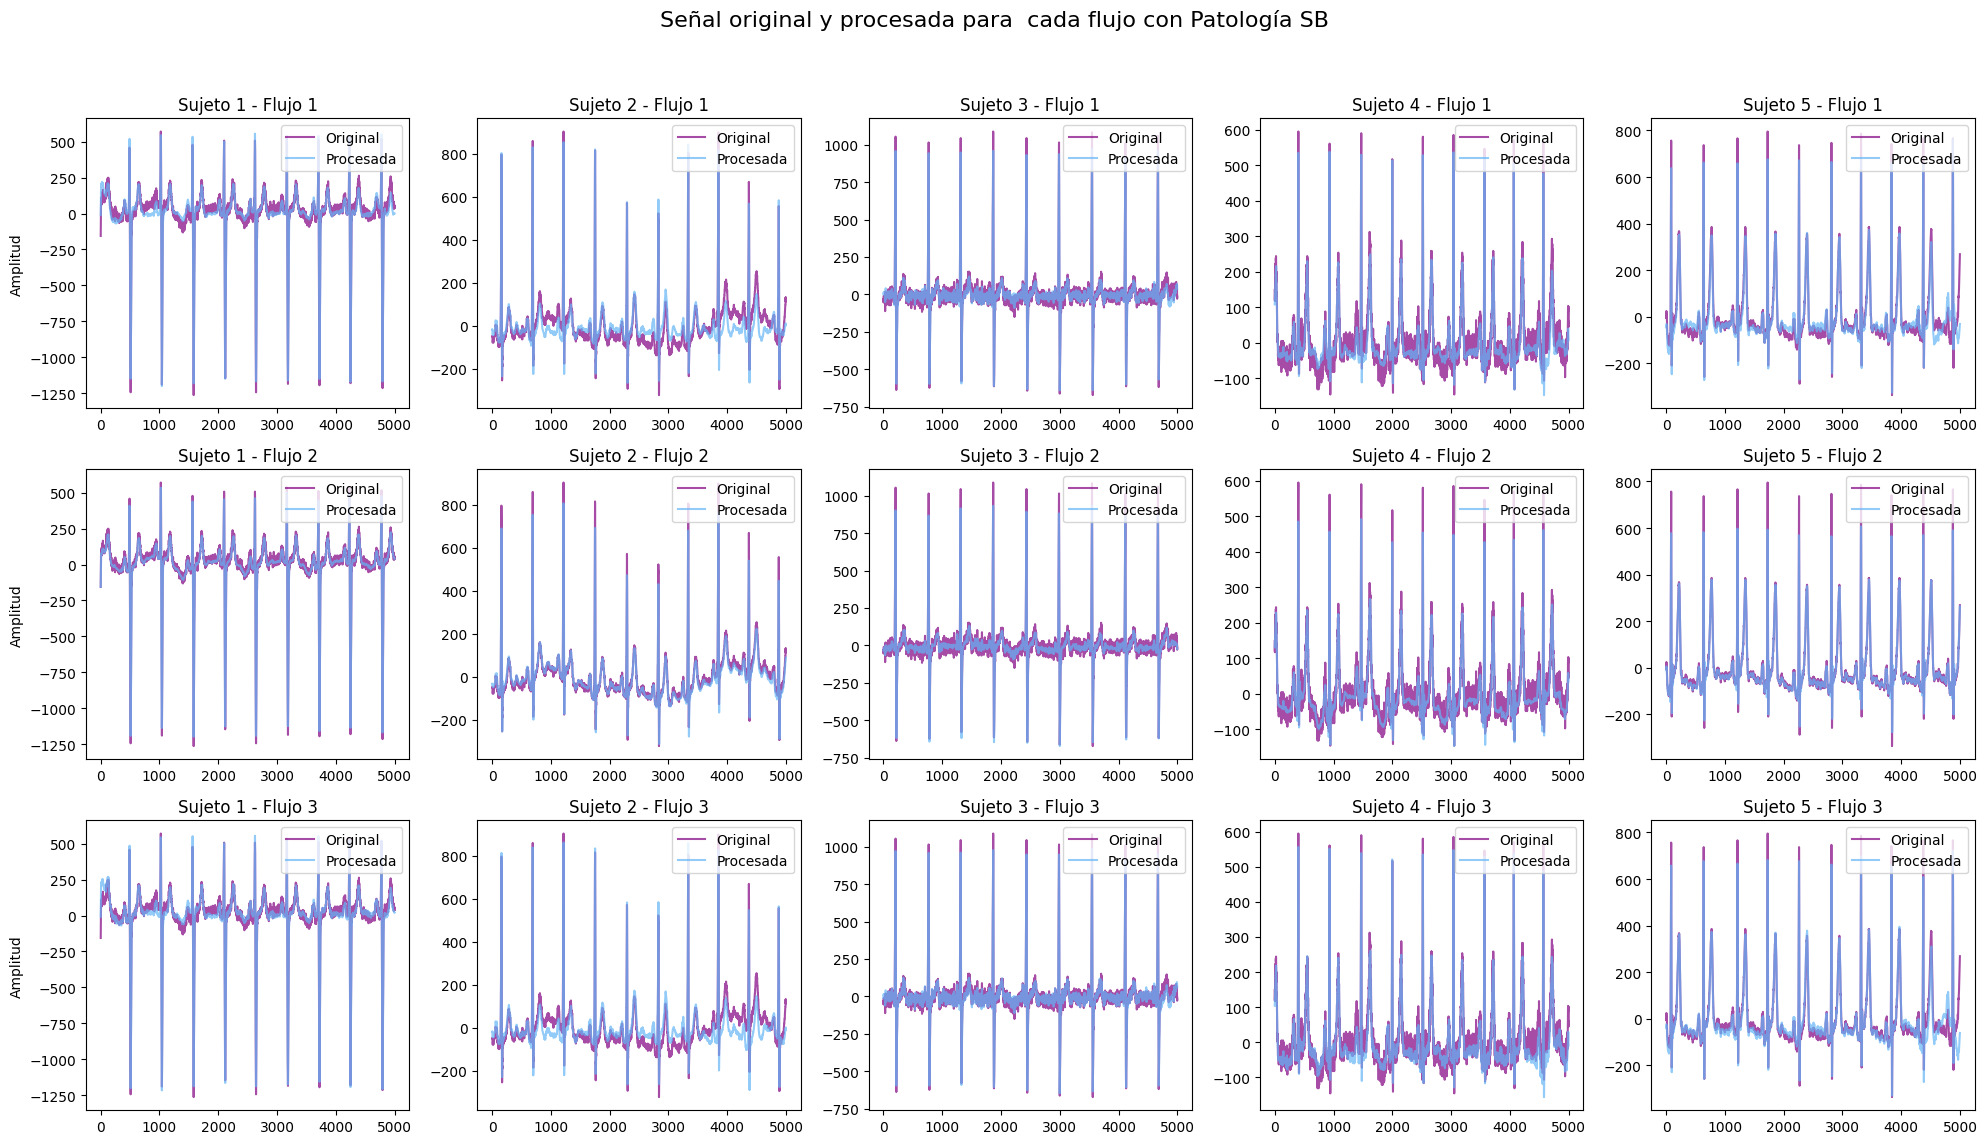

In [91]:
graficar_señales(señales_procesadas_F1_SB, señales_procesadas_F2_SB, señales_procesadas_F3_SB,tipo="SB")


* Patología: AFIB

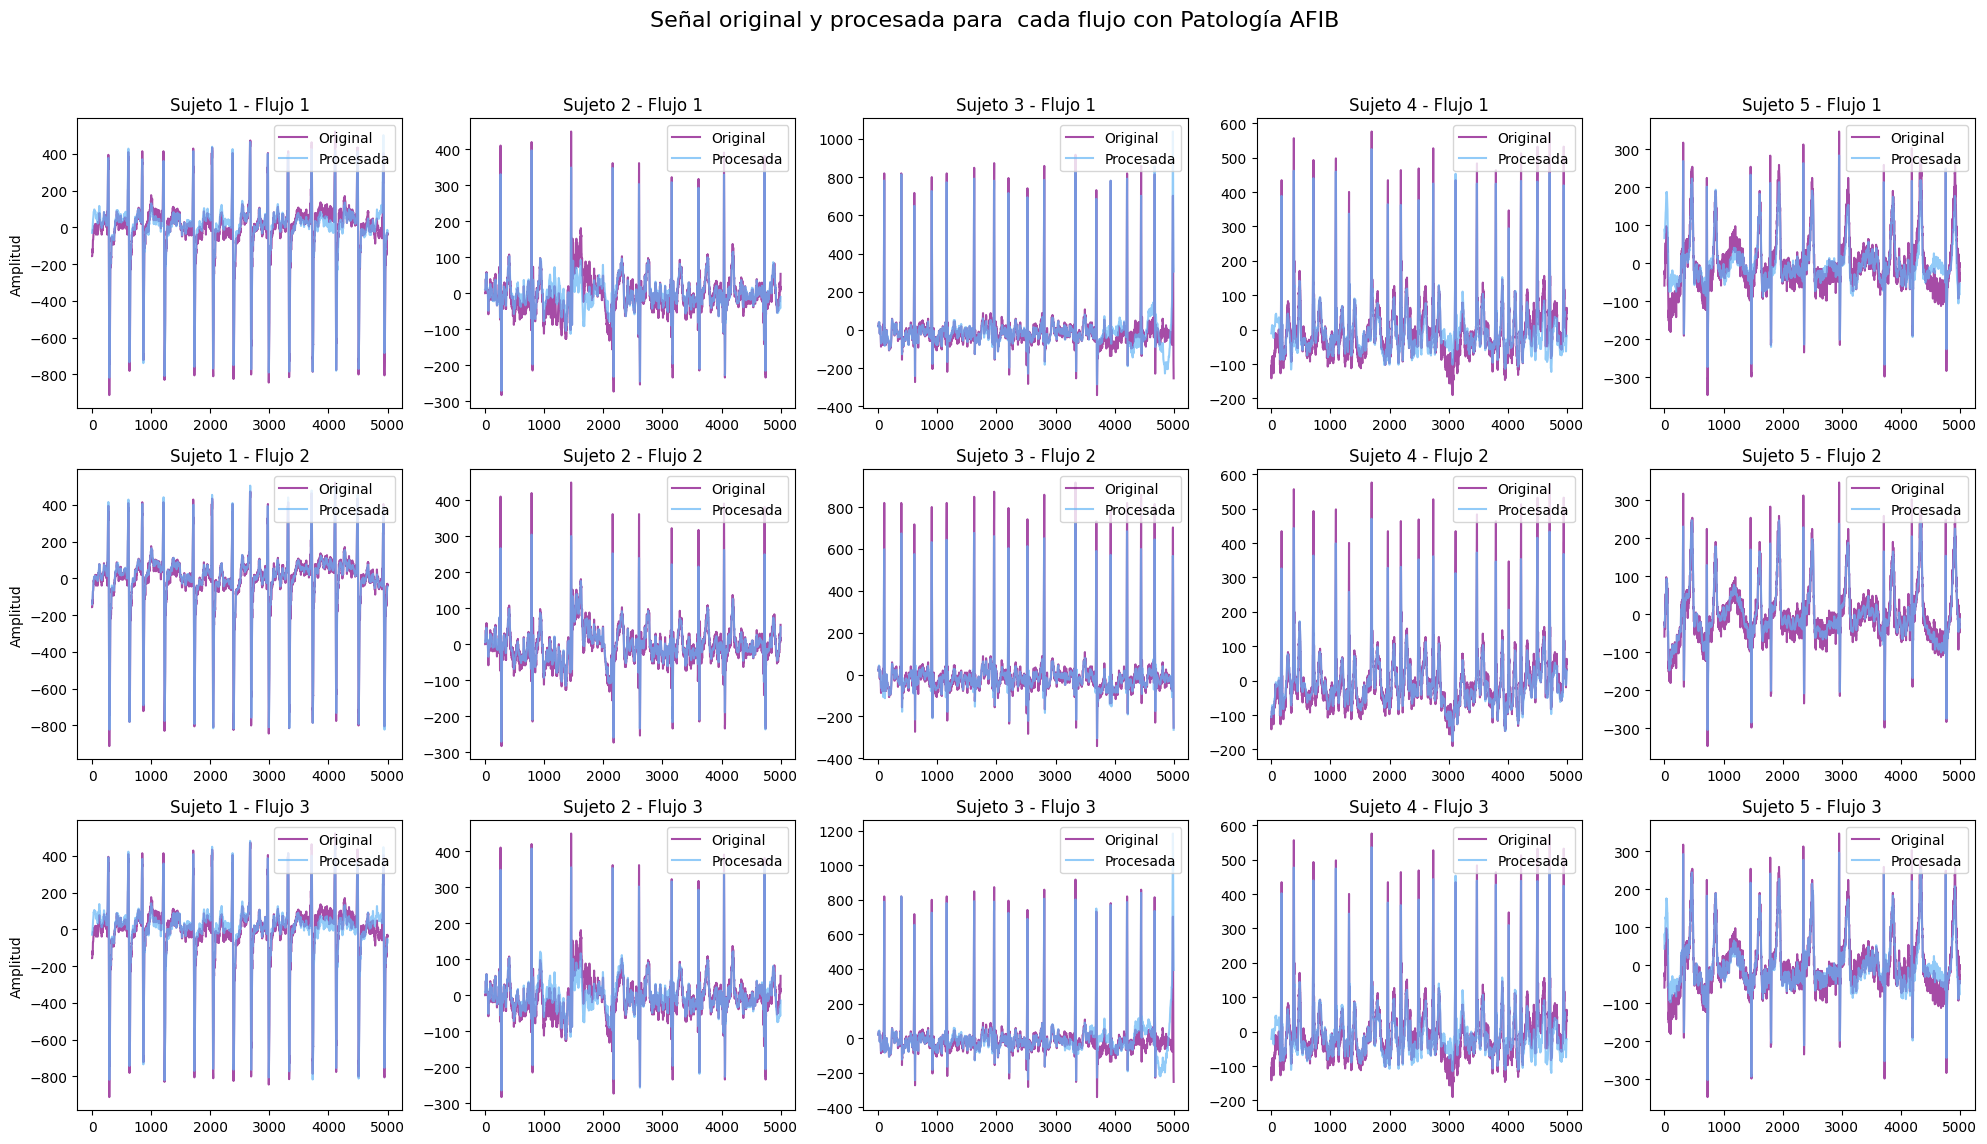

In [25]:
graficar_señales(señales_procesadas_F1_AFIB, señales_procesadas_F2_AFIB, señales_procesadas_F3_AFIB,tipo="AFIB")

<hr>

Describir los resultados obtenidos 

In [26]:
def graficar_sujeto_1(señales_F1, señales_F2, señales_F3, tipo="SB"):
    # Crear la figura con 1 columna y 3 filas (para mostrar los tres flujos)
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    fig.suptitle(f"Señal original y procesada - Sujeto 1 ({tipo})", fontsize=16)
    
    # Definir las claves para el Sujeto 1 en cada flujo
    clave_f1 = f'{tipo}_Flujo1_S1'
    clave_f2 = f'{tipo}_Flujo2_S1'
    clave_f3 = f'{tipo}_Flujo3_S1'
    
    # Obtener los datos de cada flujo para el Sujeto 1
    datos_f1 = señales_F1.get(clave_f1)
    datos_f2 = señales_F2.get(clave_f2)
    datos_f3 = señales_F3.get(clave_f3)

    if datos_f1:
        axes[0].plot(datos_f1['original'], label="Original", color='purple', alpha=0.7)
        axes[0].plot(datos_f1['procesada'], label="Procesada", color='#64B5F6', alpha=0.7)
        axes[0].set_title("Sujeto 1 - Flujo 1")
        axes[0].legend(loc="upper right")
        axes[0].set_ylabel("Amplitud")

    if datos_f2:
        axes[1].plot(datos_f2['original'], label="Original", color='purple', alpha=0.7)
        axes[1].plot(datos_f2['procesada'], label="Procesada", color='#64B5F6', alpha=0.7)
        axes[1].set_title("Sujeto 1 - Flujo 2")
        axes[1].legend(loc="upper right")
        axes[1].set_ylabel("Amplitud")

    if datos_f3:
        axes[2].plot(datos_f3['original'], label="Original", color='purple', alpha=0.7)
        axes[2].plot(datos_f3['procesada'], label="Procesada", color='#64B5F6', alpha=0.7)
        axes[2].set_title("Sujeto 1 - Flujo 3")
        axes[2].legend(loc="upper right")
        axes[2].set_ylabel("Amplitud")
        
    # Ajustar el layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

* Visualización para un sujeto con patología SB los tres flujos

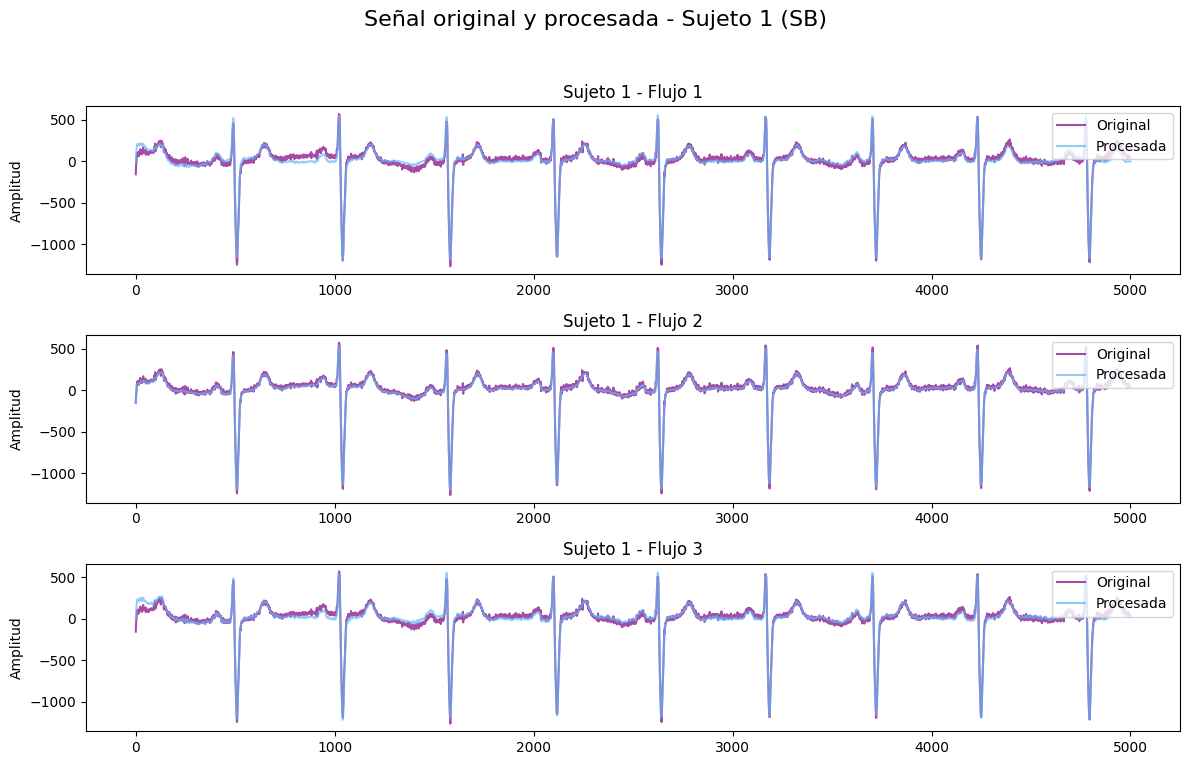

In [94]:
graficar_sujeto_1(señales_procesadas_F1_SB, señales_procesadas_F2_SB, señales_procesadas_F3_SB, tipo="SB")


* Visualización para un sujeto con patología AFIB con los tres flujos

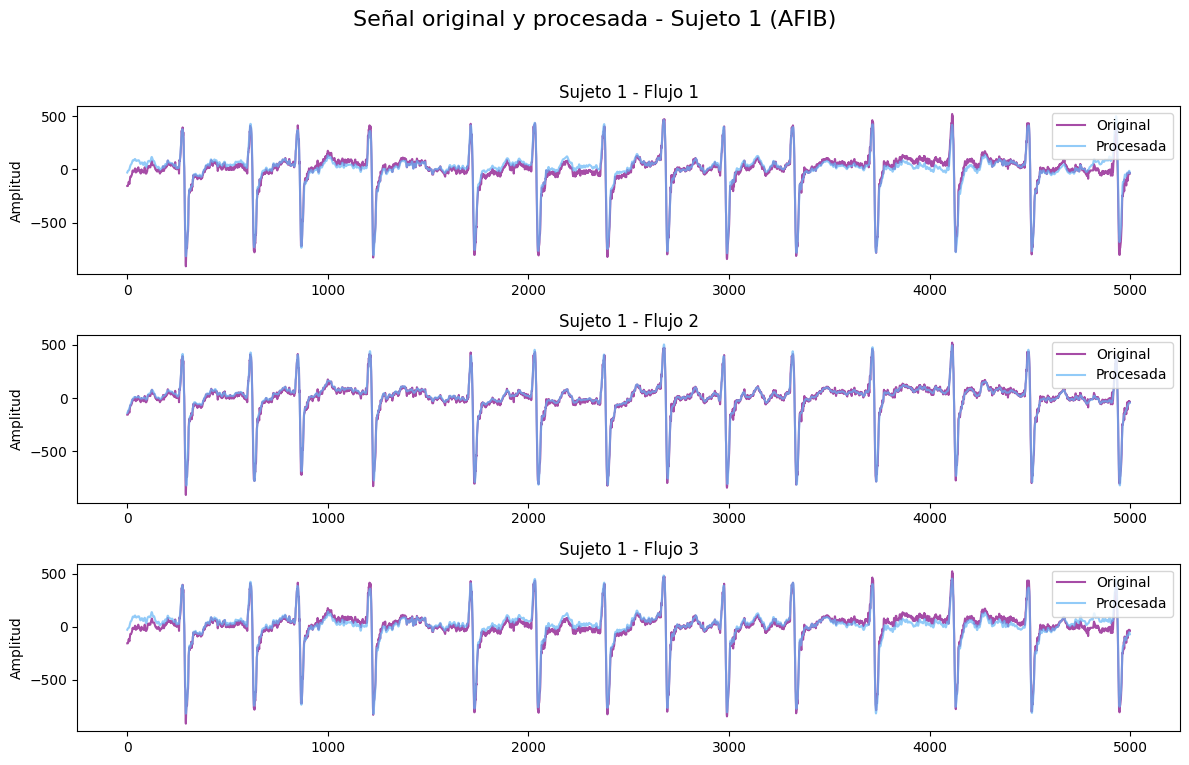

In [27]:
graficar_sujeto_1(señales_procesadas_F1_AFIB, señales_procesadas_F2_AFIB, señales_procesadas_F3_AFIB, tipo="AFIB")

<hr>

Decidir si el resto del procesamiento se hace con el flujo 1, el flujo 2 o el flujo 3

In [28]:
def seleccionar_flujo(señales_F1, señales_F2, señales_F3, tipo="SB"):
    # Inicializar un diccionario para almacenar los errores
    errores = {}

    
    for i in range(5):
        # Definir las claves para el sujeto i+1 en cada flujo
        clave_f1 = f'{tipo}_Flujo1_S{i+1}'
        clave_f2 = f'{tipo}_Flujo2_S{i+1}'
        clave_f3 = f'{tipo}_Flujo3_S{i+1}'

        # Obtener los datos de cada flujo
        datos_f1 = señales_F1.get(clave_f1)
        datos_f2 = señales_F2.get(clave_f2)
        datos_f3 = señales_F3.get(clave_f3)

        if datos_f1 and datos_f2 and datos_f3:
            # Calcular el error de cada flujo
            error_f1 = mean_squared_error(datos_f1['original'], datos_f1['procesada'])
            error_f2 = mean_squared_error(datos_f2['original'], datos_f2['procesada'])
            error_f3 = mean_squared_error(datos_f3['original'], datos_f3['procesada'])
            
            # Almacenar los errores
            errores[f'Sujeto {i+1}'] = {
                'Flujo 1': error_f1,
                'Flujo 2': error_f2,
                'Flujo 3': error_f3
            }

    # Seleccionar el flujo con el menor error promedio
    error_promedio_flujo1 = np.mean([errores[f'Sujeto {i+1}']['Flujo 1'] for i in range(5)])
    error_promedio_flujo2 = np.mean([errores[f'Sujeto {i+1}']['Flujo 2'] for i in range(5)])
    error_promedio_flujo3 = np.mean([errores[f'Sujeto {i+1}']['Flujo 3'] for i in range(5)])

    # Seleccionar el flujo con el menor error promedio
    flujo_ideal = min([(error_promedio_flujo1, "Flujo 1"), (error_promedio_flujo2, "Flujo 2"), (error_promedio_flujo3, "Flujo 3")])[1]
    
    return flujo_ideal,error_promedio_flujo1,error_promedio_flujo2,error_promedio_flujo3



In [29]:
flujo_ideal, error_promedio_flujo1, error_promedio_flujo2, error_promedio_flujo3 = seleccionar_flujo(señales_procesadas_F1_SB, señales_procesadas_F2_SB, señales_procesadas_F3_SB, tipo="SB")
print(f"El flujo de procesamiento más adecuado para señales SB es: {flujo_ideal}")

# Crear un diccionario con los errores por flujo
errores = {
    'Flujo': ['F1', 'F2', 'F3'],
    'Error Promedio': [error_promedio_flujo1, error_promedio_flujo2, error_promedio_flujo3]
}

# Crear el DataFrame a partir del diccionario
df_errores = pd.DataFrame(errores)

# Mostrar el DataFrame
df_errores.head()

El flujo de procesamiento más adecuado para señales SB es: Flujo 2


,Flujo,Error Promedio
0,F1,1287.703289
1,F2,571.323294
2,F3,1245.566885


In [30]:
flujo_ideal, error_promedio_flujo1, error_promedio_flujo2, error_promedio_flujo3 = seleccionar_flujo(señales_procesadas_F1_AFIB, señales_procesadas_F2_AFIB, señales_procesadas_F3_AFIB, tipo="AFIB")
print(f"El flujo de procesamiento más adecuado para señales AFIB es: {flujo_ideal}")
# Crear un diccionario con los errores por flujo
errores = {
    'Flujo': ['F1', 'F2', 'F3'],
    'Error Promedio': [error_promedio_flujo1, error_promedio_flujo2, error_promedio_flujo3]
}

# Crear el DataFrame a partir del diccionario
df_errores = pd.DataFrame(errores)

# Mostrar el DataFrame
df_errores.head()

El flujo de procesamiento más adecuado para señales AFIB es: Flujo 2


,Flujo,Error Promedio
0,F1,1445.792063
1,F2,516.562210
2,F3,1583.610341


<hr>

Con el flujo seleccionado procesar las señales de la base de datos ECGData.zip derivación II. En este punto deberíamos estar en el mismo punto donde partimos en el proyecto 2, con señales filtradas.

A las señales filtradas con el flujo seleccionado aplicar el procesamiento de normalización usado en el proyecto 2.

In [99]:
def detrending(signals):
    detrended_signals = detrend(signals, axis=0)
    return detrended_signals

def compression(timeseries: np.ndarray) -> np.ndarray:
  """
    Normaliza la señal recibida, poniendola entre 0 y 1.
  """
  max = timeseries.max()
  min = timeseries.min()
  
  # Aplicar la normalización min-max
  return (timeseries - min) / (max - min)

<hr>

Para cada señal extraer la frecuencia que contiene la máxima potencia usando Welch (15%)

In [100]:

def powerSpectrumWelch(signal: np.ndarray, fs: int = 500) -> dict:
    # Calcular la longitud de la señal
    len_signalecg = len(signal)
    
    # Ajustar nperseg según la longitud de la señal
    nperseg = min(512, len_signalecg)  # Ancho de la ventana, nperseg no debe ser mayor que la longitud de la señal
    
    # Solapamiento de las ventanas
    noverlap = int(nperseg*0.75)  # Solapamiento del 50%

    # Usar la ventana de Hanning
    ventana = np.hanning(nperseg)

    # Calcular el periodograma de Welch con el parámetro `window` especificado
    freqs, Pxx = welch(signal, fs, window=ventana, nperseg=nperseg, noverlap=noverlap)
    
    # Encontrar la frecuencia máxima y la potencia máxima
    maxV = np.argmax(Pxx)
    maxFf = round(freqs[maxV], 5)  # Frecuencia máxima
    maxP = Pxx[maxV]  # Potencia máxima
    maxF = np.sqrt(maxP)  # Valor de la FFT (amplitud)

    # Retornar los resultados
    return {
        'frequencies': freqs,
        'power_spectrum': Pxx,
        'max_frequency': maxFf,
        'max_power': maxP,
        'max_value': maxF,
    }

def powerSpectrumFFT(signal: np.ndarray) -> dict:
    # Calcular la FFT
    FT = np.fft.fft(signal)
    FT = np.abs(FT[:len(FT)//2])  # Tomar solo la mitad positiva
    freqs = np.fft.fftfreq(len(signal), 1/500)
    freqs = freqs[:len(freqs)//2]  # Frecuencias correspondientes
    power = np.abs(FT)**2  # Potencia de la FFT
    maxV = np.argmax(power)  # Índice del valor máximo
    maxFf = round(freqs[maxV], 5)  # Frecuencia máxima
    maxP = power[maxV]  # Potencia máxima
    maxF = FT[maxV]  # Valor de la FFT en la frecuencia máxima

    # Retornar los resultados
    return {
        'frequencies': freqs,
        'FFT': FT,
        'max_frequency': maxFf,
        'max_power': maxP,
        'max_value': maxF,
    }


<hr>

Crear una rutina que aplique sobre todos los archivos de la base de datos las rutina 3 al 5 y almacene los resultados en un dataframe donde se pueda registro, tipo de patología y el frecuencia de máxima potencia (fMP):

In [101]:
def procesar_archivos_y_estadisticas(ruta_archivos, columnas, fs, diagnostics_df):
    # Listas para almacenar los resultados de fMP y estadísticas
    resultados_fmp = []  # Para almacenar resultados de fMP
    resultados_stat = []  # Para almacenar estadísticas (media, mediana, desviación)

    # Obtener la lista de archivos a procesar según los nombres en diagnostics_df
    archivos = [file_name for file_name in os.listdir(ruta_archivos) if file_name.endswith('.csv')]
    # Filtrar los archivos para que solo contengan los nombres en diagnostics_df
    archivos_validos = [file_name for file_name in archivos if file_name.split('.')[0] in diagnostics_df['FileName'].values]

    total_archivos = len(archivos_validos)

    # Iterar sobre los archivos en la lista de archivos válidos
    for i, file_name in enumerate(archivos_validos):
        if file_name.endswith('.csv'):
            ruta_archivo = os.path.join(ruta_archivos, file_name)
            
            # Leer el archivo de señal y extraer la derivación II
            df = pd.read_csv(ruta_archivo, delimiter=',', names=columnas, header=0)
            signal = df['II'].to_numpy()  # Extraer derivación II

            # Aplicar el flujo de procesamiento 2 (detrending, wavelet, pasa bajas)
            signal_detrend = detrending_F2(signal)  # Detrending
            signal_filtro_wavelet = filtro_wavelet(signal_detrend)  # Wavelet
            signal_filtro_pasa_bajas = filtro_pasa_bajas_F2(signal_filtro_wavelet, fs)  # Pasa bajas

            # Luego aplicar el proceso de compresión y detrending adicional
            signal_detrend_compressed = detrending(compression(detrending(signal_filtro_pasa_bajas)))

            # Aplicar el power spectrum (análisis de frecuencias)
            power_spectrum_results = powerSpectrumWelch(signal_detrend_compressed)
            power_spectrum_results_FFT = powerSpectrumFFT(signal_detrend_compressed)

            # Obtener la frecuencia máxima de potencia (fMP)
            fmp = power_spectrum_results['max_frequency']
            fmp_FFT = power_spectrum_results_FFT['max_frequency']
            # Determinar el tipo de patología (por ejemplo, SB o AFIB, basado en el archivo o diagnóstico)
            # Buscar en diagnostics_df
            diagnosis_row = diagnostics_df[diagnostics_df.FileName == file_name.split('.')[0]]
            if not diagnosis_row.empty:
                pathology = diagnosis_row.Rhythm.to_numpy()[0]
            else:
                # Si no se encuentra diagnóstico, asignar valor predeterminado
                pathology = 'Desconocido'

            # Guardar el resultado del análisis de la frecuencia máxima de potencia
            resultados_fmp.append([file_name, pathology, fmp_FFT,fmp])

            # Obtener estadísticas de la señal procesada
            media = np.mean(signal_detrend_compressed)
            mediana = np.median(signal_detrend_compressed)
            desviacion = np.std(signal_detrend_compressed)

            # Guardar las estadísticas
            resultados_stat.append([file_name, pathology, media, mediana, desviacion])

        # Mostrar el progreso
        print(f"Procesado {i + 1} de {total_archivos} archivos.")

    # Crear DataFrames para los resultados
    df_fmp = pd.DataFrame(resultados_fmp, columns=['Archivo', 'Estado', 'fMP(FFT)','fMP(Welch)'])
    df_stat = pd.DataFrame(resultados_stat, columns=['Archivo', 'Estado', 'Media', 'Mediana', 'Desviacion'])

    return df_fmp, df_stat


<hr>

Procesar Datos

In [102]:
columnas = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
fs = 500  # Frecuencia de muestreo, ajusta según tus datos

# Ruta donde están los archivos CSV con las señales
ruta_archivos = r"C:\Users\luisa\Downloads\ECGData\ECGData"

# Llamar a la función para procesar los archivos
df_fmp, df_stat = procesar_archivos_y_estadisticas(ruta_archivos, columnas, fs, datos)



Procesado 1 de 5669 archivos.
Procesado 2 de 5669 archivos.
Procesado 3 de 5669 archivos.
Procesado 4 de 5669 archivos.
Procesado 5 de 5669 archivos.
Procesado 6 de 5669 archivos.
Procesado 7 de 5669 archivos.
Procesado 8 de 5669 archivos.
Procesado 9 de 5669 archivos.
Procesado 10 de 5669 archivos.
Procesado 11 de 5669 archivos.
Procesado 12 de 5669 archivos.
Procesado 13 de 5669 archivos.
Procesado 14 de 5669 archivos.
Procesado 15 de 5669 archivos.
Procesado 16 de 5669 archivos.
Procesado 17 de 5669 archivos.
Procesado 18 de 5669 archivos.
Procesado 19 de 5669 archivos.
Procesado 20 de 5669 archivos.
Procesado 21 de 5669 archivos.
Procesado 22 de 5669 archivos.
Procesado 23 de 5669 archivos.
Procesado 24 de 5669 archivos.
Procesado 25 de 5669 archivos.
Procesado 26 de 5669 archivos.
Procesado 27 de 5669 archivos.
Procesado 28 de 5669 archivos.
Procesado 29 de 5669 archivos.
Procesado 30 de 5669 archivos.
Procesado 31 de 5669 archivos.
Procesado 32 de 5669 archivos.
Procesado 33 de 5

In [103]:
# Mostrar los DataFrames
print("Frecuencia máxima de potencia (fMP):")
print(df_fmp)
print("\nEstadísticas de la señal procesada:")
print(df_stat)

Frecuencia máxima de potencia (fMP):
                             Archivo Estado  fMP(FFT)  fMP(Welch)
0     MUSE_20180111_155154_74000.csv   AFIB       9.7     4.88281
1     MUSE_20180111_155203_15000.csv   AFIB       4.2     3.90625
2     MUSE_20180111_155758_17000.csv     SB       0.9     3.90625
3     MUSE_20180111_155839_67000.csv     SB       1.0     0.97656
4     MUSE_20180111_155859_36000.csv     SB       0.9     0.97656
...                              ...    ...       ...         ...
5664  MUSE_20180712_161449_58000.csv   AFIB       0.2     0.97656
5665  MUSE_20180712_161451_72000.csv   AFIB       0.1     0.97656
5666  MUSE_20180712_161452_78000.csv   AFIB       0.3     0.97656
5667  MUSE_20180712_161503_00000.csv   AFIB       0.2     3.90625
5668  MUSE_20180712_161505_16000.csv   AFIB       0.1     0.97656

[5669 rows x 4 columns]

Estadísticas de la señal procesada:
                             Archivo Estado         Media   Mediana  \
0     MUSE_20180111_155154_74000.csv  

<hr>

* Guardar datos

In [104]:
# Ruta donde quieres guardar los resultados
save_path_results = r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto3\results.csv"
save_path_stats = r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto3\stats.csv"

# Guardar el DataFrame de resultados
df_fmp.to_csv(save_path_results, index=False)  # index=False evita que se guarde el índice de pandas como columna extra

# Guardar el DataFrame de estadísticas descriptivas
df_stat.to_csv(save_path_stats, index=False)

print("Archivos guardados exitosamente.")

Archivos guardados exitosamente.


<hr>

<h3><strong>Estadistica</strong></h3>

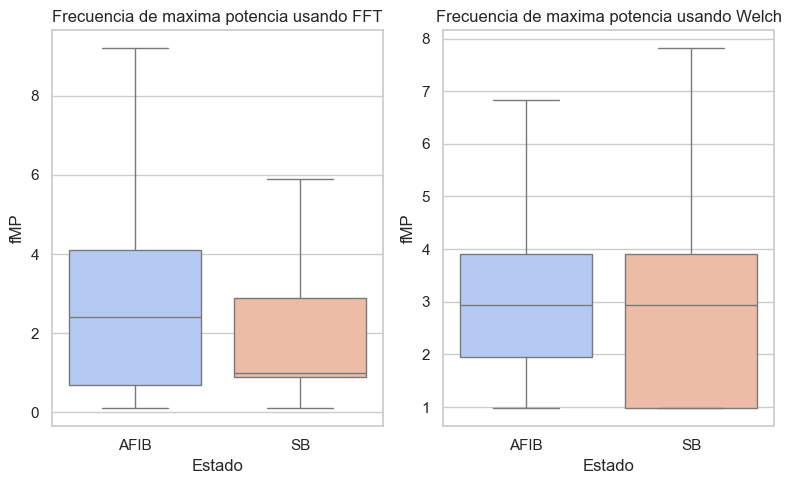

In [105]:
# Establecer estilo de fondo blanco con grid y paleta de colores
sns.set(style="whitegrid")
palette = "coolwarm"

# Crear un boxplot para la columna 'fMP' y 'sFSB', agrupado por 'Estado'
plt.figure(figsize=(8, 5))

# Boxplot para 'fMP'
plt.subplot(1, 2, 1)  # Crear un subplot 1x2 y el primer gráfico
sns.boxplot(x='Estado', y='fMP(FFT)', data=df_fmp, palette=palette,showfliers=False)
plt.title('Frecuencia de maxima potencia usando FFT')
plt.ylabel('fMP')

# Boxplot para 'sFSB'
plt.subplot(1, 2, 2)  # Crear el segundo gráfico
sns.boxplot(x='Estado', y='fMP(Welch)', data=df_fmp, palette=palette,showfliers=False)
plt.title('Frecuencia de maxima potencia usando Welch')
plt.ylabel('fMP')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

* Prueba de normalidad y homocedasticidad

In [106]:
# Definir las métricas que deseas analizar
metrics = ['fMP(FFT)', 'fMP(Welch)']  

# Inicializa una lista para almacenar los resultados
results = []

# Realiza pruebas para cada métrica
for metric in metrics:
    # Filtrar los datos para cada estado
    data_SB = df_fmp[df_fmp['Estado'] == 'SB'][metric].dropna()
    data_AFIB = df_fmp[df_fmp['Estado'] == 'AFIB'][metric].dropna()

    # Prueba de normalidad (Shapiro-Wilk)
    stat_normality_SB, p_value_normality_SB = stats.shapiro(data_SB)
    normality_result_SB = 'Normal' if p_value_normality_SB > 0.05 else 'No normal'

    stat_normality_AFIB, p_value_normality_AFIB = stats.shapiro(data_AFIB)
    normality_result_AFIB = 'Normal' if p_value_normality_AFIB > 0.05 else 'No normal'

    # Prueba de homocedasticidad (Levene)
    stat_homoscedasticity, p_value_homoscedasticity = stats.levene(data_SB, data_AFIB)
    homoscedasticity_result = 'Homocedástico' if p_value_homoscedasticity > 0.05 else 'Heterocedástico'

    # Agrega los resultados a la lista
    results.append({
        'Metric': metric,
        'SB Normality (p-value)': p_value_normality_SB,
        'SB Normality Result': normality_result_SB,
        'AFIB Normality (p-value)': p_value_normality_AFIB,
        'AFIB Normality Result': normality_result_AFIB,
        'Homoscedasticity (p-value)': p_value_homoscedasticity,
        'Homoscedasticity Result': homoscedasticity_result
    })

# Crea un DataFrame con los resultados
results_df_stats = pd.DataFrame(results)

# Muestra el DataFrame
results_df_stats


,Metric,SB Normality (p-value),SB Normality Result,AFIB Normality (p-value),AFIB Normality Result,Homoscedasticity (p-value),Homoscedasticity Result
0,fMP(FFT),3.913549e-58,No normal,1.867383e-38,No normal,5.850273e-66,Heterocedástico
1,fMP(Welch),2.740228e-56,No normal,9.452968e-40,No normal,2.106936e-01,Homocedástico


* Prueba No parametrica - U de Mann Whitnney

In [107]:
# Definir las métricas a analizar
metrics = ['fMP(FFT)', 'fMP(Welch)']

# Inicializa una lista para almacenar los resultados
results = []

# Realiza pruebas para cada métrica
for metric in metrics:
    data_SB = pd.to_numeric(df_fmp[df_fmp['Estado'] == 'SB'][metric], errors='coerce').dropna()
    data_AFIB = pd.to_numeric(df_fmp[df_fmp['Estado'] == 'AFIB'][metric], errors='coerce').dropna()

    # Prueba U de Mann-Whitney
    stat, p_value = stats.mannwhitneyu(data_SB, data_AFIB)

    # Determinar si hay diferencia significativa
    significant = 'Hay diferencia Significativa' if p_value < 0.05 else 'No hay diferencia significativa'

    # Agregar los resultados a la lista
    results.append({
        'Metric': metric,
        'Mann-Whitney U (stat)': stat,
        'p-value': p_value,
        'Significance': significant
    })

# Crear un DataFrame con los resultados
results_df_2 = pd.DataFrame(results)

# Mostrar el DataFrame con los resultados
results_df_2


,Metric,Mann-Whitney U (stat),p-value,Significance
0,fMP(FFT),2787542.5,2.971324e-32,Hay diferencia Significativa
1,fMP(Welch),2785237.5,3.569328e-34,Hay diferencia Significativa


<hr>
<h3><strong>Estadistica Descriptiva</strong></h3>

In [108]:
AFIB , SB = df_stat.groupby('Estado')

In [109]:
AFIB2 , SB2 = df_fmp.groupby('Estado')

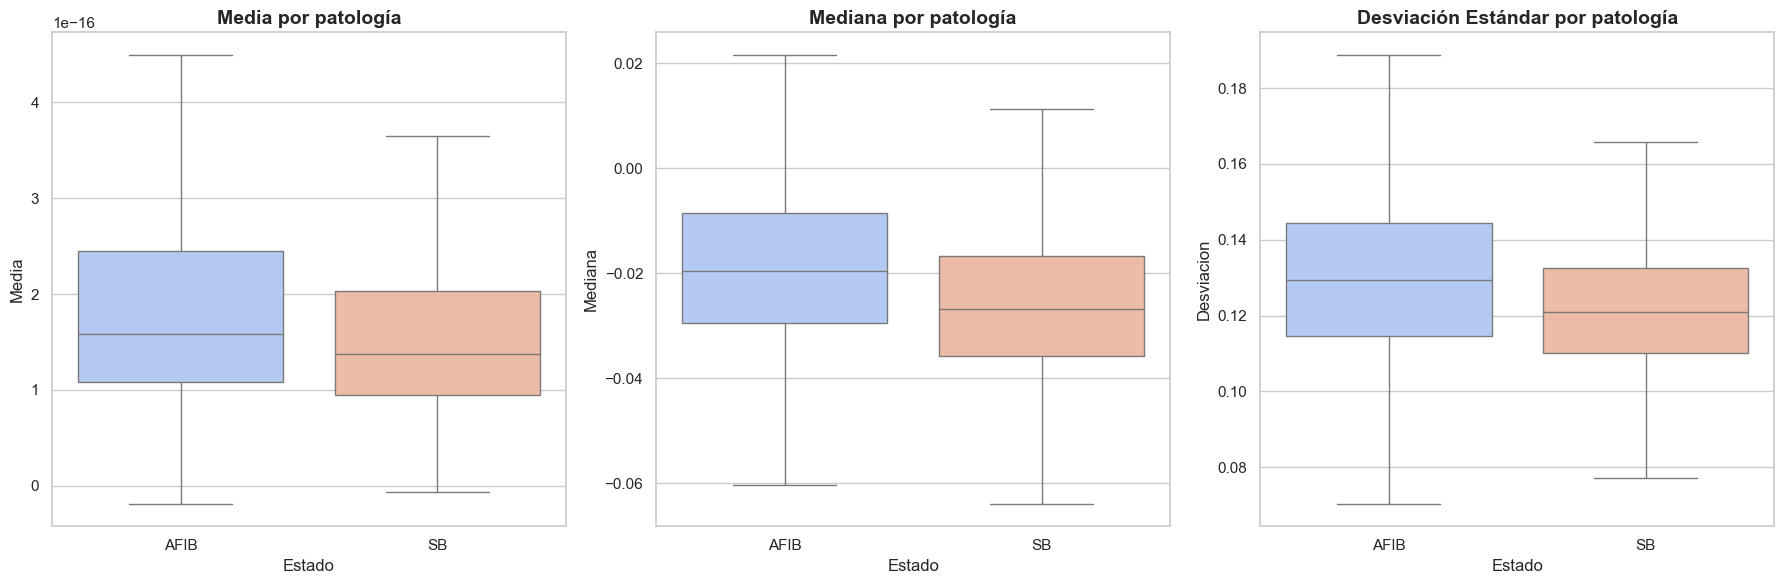

In [110]:
# Configurar el estilo y la paleta
sns.set(style="whitegrid")
palette = "coolwarm"  # Paleta de colores

# Crear subplots para las tres métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Una fila, tres columnas

# Diagrama de cajas para la media
sns.boxplot(x='Estado', y='Media', data=df_stat, palette=palette, ax=axes[0],showfliers=False)
axes[0].set_title('Media por patología', fontsize=14, fontweight='bold')

# Diagrama de cajas para la mediana
sns.boxplot(x='Estado', y='Mediana', data=df_stat, palette=palette, ax=axes[1],showfliers=False)
axes[1].set_title('Mediana por patología', fontsize=14, fontweight='bold')

# Diagrama de cajas para la desviación estándar
sns.boxplot(x='Estado', y='Desviacion', data=df_stat, palette=palette, ax=axes[2],showfliers=False)
axes[2].set_title('Desviación Estándar por patología', fontsize=14, fontweight='bold')

# Ajustar el layout para que no se solapen los títulos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

<hr>

<h3><strong>Estadistica Inferencial para datos descriptivos</strong></h3>

* Prueba de normalidad y homocedasticidad

In [111]:
# Definir las métricas que deseas analizar
metrics = ['Media', 'Mediana', 'Desviacion']  

# Inicializa una lista para almacenar los resultados
results = []

# Realiza pruebas para cada métrica
for metric in metrics:
    # Filtrar los datos para cada estado
    data_SB = df_stat[df_stat['Estado'] == 'SB'][metric].dropna()
    data_AFIB = df_stat[df_stat['Estado'] == 'AFIB'][metric].dropna()

    # Prueba de normalidad (Shapiro-Wilk)
    stat_normality_SB, p_value_normality_SB = stats.shapiro(data_SB)
    normality_result_SB = 'Normal' if p_value_normality_SB > 0.05 else 'No normal'

    stat_normality_AFIB, p_value_normality_AFIB = stats.shapiro(data_AFIB)
    normality_result_AFIB = 'Normal' if p_value_normality_AFIB > 0.05 else 'No normal'

    # Prueba de homocedasticidad (Levene)
    stat_homoscedasticity, p_value_homoscedasticity = stats.levene(data_SB, data_AFIB)
    homoscedasticity_result = 'Homocedástico' if p_value_homoscedasticity > 0.05 else 'Heterocedástico'

    # Agrega los resultados a la lista
    results.append({
        'Metric': metric,
        'SB Normality (p-value)': p_value_normality_SB,
        'SB Normality Result': normality_result_SB,
        'AFIB Normality (p-value)': p_value_normality_AFIB,
        'AFIB Normality Result': normality_result_AFIB,
        'Homoscedasticity (p-value)': p_value_homoscedasticity,
        'Homoscedasticity Result': homoscedasticity_result
    })

# Crea un DataFrame con los resultados
results_df_2 = pd.DataFrame(results)

# Muestra el DataFrame
results_df_2


,Metric,SB Normality (p-value),SB Normality Result,AFIB Normality (p-value),AFIB Normality Result,Homoscedasticity (p-value),Homoscedasticity Result
0,Media,3.212028e-46,No normal,3.911509e-31,No normal,1.994653e-09,Heterocedástico
1,Mediana,1.925033e-09,No normal,3.173201e-13,No normal,3.741580e-06,Heterocedástico
2,Desviacion,1.894002e-29,No normal,1.190569e-06,No normal,1.424960e-24,Heterocedástico


* Prueba No parametrica - U de Mann-Whithney

In [112]:
# Definir las métricas que deseas analizar
metrics = ['Media', 'Mediana', 'Desviacion']  # Asegúrate de que estas columnas existan en stats_df

# Inicializa una lista para almacenar los resultados
results = []

# Realiza la prueba para cada métrica
for metric in metrics:
    # Filtrar los datos para cada estado
    data_SB = df_stat[df_stat['Estado'] == 'SB'][metric].dropna()
    data_AFIB = df_stat[df_stat['Estado'] == 'AFIB'][metric].dropna()

    # Prueba U de Mann-Whitney
    u_statistic, p_value_mann_whitney = stats.mannwhitneyu(data_SB, data_AFIB, alternative='two-sided')

    # Determinar si hay una diferencia significativa
    significance = 'Hay Diferencia Significativa' if p_value_mann_whitney <= 0.05 else 'No hay diferencia significativa'

    # Agrega los resultados a la lista
    results.append({
        'Metric': metric,
        'Mann-Whitney U Statistic': u_statistic,
        'Mann-Whitney p-value': p_value_mann_whitney,
        'Significancia': significance
    })

# Crea un DataFrame con los resultados
results_df = pd.DataFrame(results)

# Muestra el DataFrame
results_df



,Metric,Mann-Whitney U Statistic,Mann-Whitney p-value,Significancia
0,Media,2962364.0,2.723390e-18,Hay Diferencia Significativa
1,Mediana,2511302.0,5.968149e-62,Hay Diferencia Significativa
2,Desviacion,2728425.0,1.389017e-37,Hay Diferencia Significativa


<hr>

<h3><strong>Comparación Proyecto 2 y Proyecto 3</strong></h3>

* Datos Proyecto 2

In [113]:
# Ruta al archivo CSV
ruta_csv = r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto2\results.csv"
ruta_csv_stat = r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto2\stats.csv"

# Cargar el archivo CSV
df_2 = pd.read_csv(ruta_csv)
df_S2 = pd.read_csv(ruta_csv_stat)

# Filtrar el DataFrame para obtener los valores de fMP para estos sujetos
resultados_fmp2 = df_2[['Archivo', 'Estado','fMP(FFT)','fMP(Welch)']]

# Mostrar los resultados
print(resultados_fmp2)
print(df_S2)

                         Archivo Estado  fMP(FFT)  fMP(Welch)
0     MUSE_20180111_155154_74000   AFIB       9.7     4.88281
1     MUSE_20180111_155203_15000   AFIB       2.7     3.90625
2     MUSE_20180111_155758_17000     SB       3.7     3.90625
3     MUSE_20180111_155839_67000     SB       2.9     2.92969
4     MUSE_20180111_155859_36000     SB       2.8     1.95312
...                          ...    ...       ...         ...
5664  MUSE_20180712_161449_58000   AFIB      12.4    13.67188
5665  MUSE_20180712_161451_72000   AFIB       3.9     3.90625
5666  MUSE_20180712_161452_78000   AFIB       3.2     3.90625
5667  MUSE_20180712_161503_00000   AFIB       4.1     3.90625
5668  MUSE_20180712_161505_16000   AFIB       2.6     1.95312

[5669 rows x 4 columns]
                         Archivo Estado         Media   Mediana  Desviación
0     MUSE_20180111_155154_74000   AFIB  3.224976e-16 -0.030115    0.125835
1     MUSE_20180111_155203_15000   AFIB  1.080025e-16 -0.031761    0.120065
2  

* Datos Proyecto 3

In [114]:
# Ruta al archivo CSV
ruta_csv = r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto3\results.csv"
ruta_csv_stat = r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto3\stats.csv"

# Cargar el archivo CSV
df_3 = pd.read_csv(ruta_csv)
df_S3 = pd.read_csv(ruta_csv_stat)

# Filtrar el DataFrame para obtener los valores de fMP para estos sujetos
resultados_fmp3 = df_3[['Archivo', 'Estado','fMP(FFT)','fMP(Welch)']]

# Mostrar los resultados
print(resultados_fmp3)
print(df_S3)

                             Archivo Estado  fMP(FFT)  fMP(Welch)
0     MUSE_20180111_155154_74000.csv   AFIB       9.7     4.88281
1     MUSE_20180111_155203_15000.csv   AFIB       4.2     3.90625
2     MUSE_20180111_155758_17000.csv     SB       0.9     3.90625
3     MUSE_20180111_155839_67000.csv     SB       1.0     0.97656
4     MUSE_20180111_155859_36000.csv     SB       0.9     0.97656
...                              ...    ...       ...         ...
5664  MUSE_20180712_161449_58000.csv   AFIB       0.2     0.97656
5665  MUSE_20180712_161451_72000.csv   AFIB       0.1     0.97656
5666  MUSE_20180712_161452_78000.csv   AFIB       0.3     0.97656
5667  MUSE_20180712_161503_00000.csv   AFIB       0.2     3.90625
5668  MUSE_20180712_161505_16000.csv   AFIB       0.1     0.97656

[5669 rows x 4 columns]
                             Archivo Estado         Media   Mediana  \
0     MUSE_20180111_155154_74000.csv   AFIB  2.767564e-16 -0.024749   
1     MUSE_20180111_155203_15000.csv   AF

* Estadistica

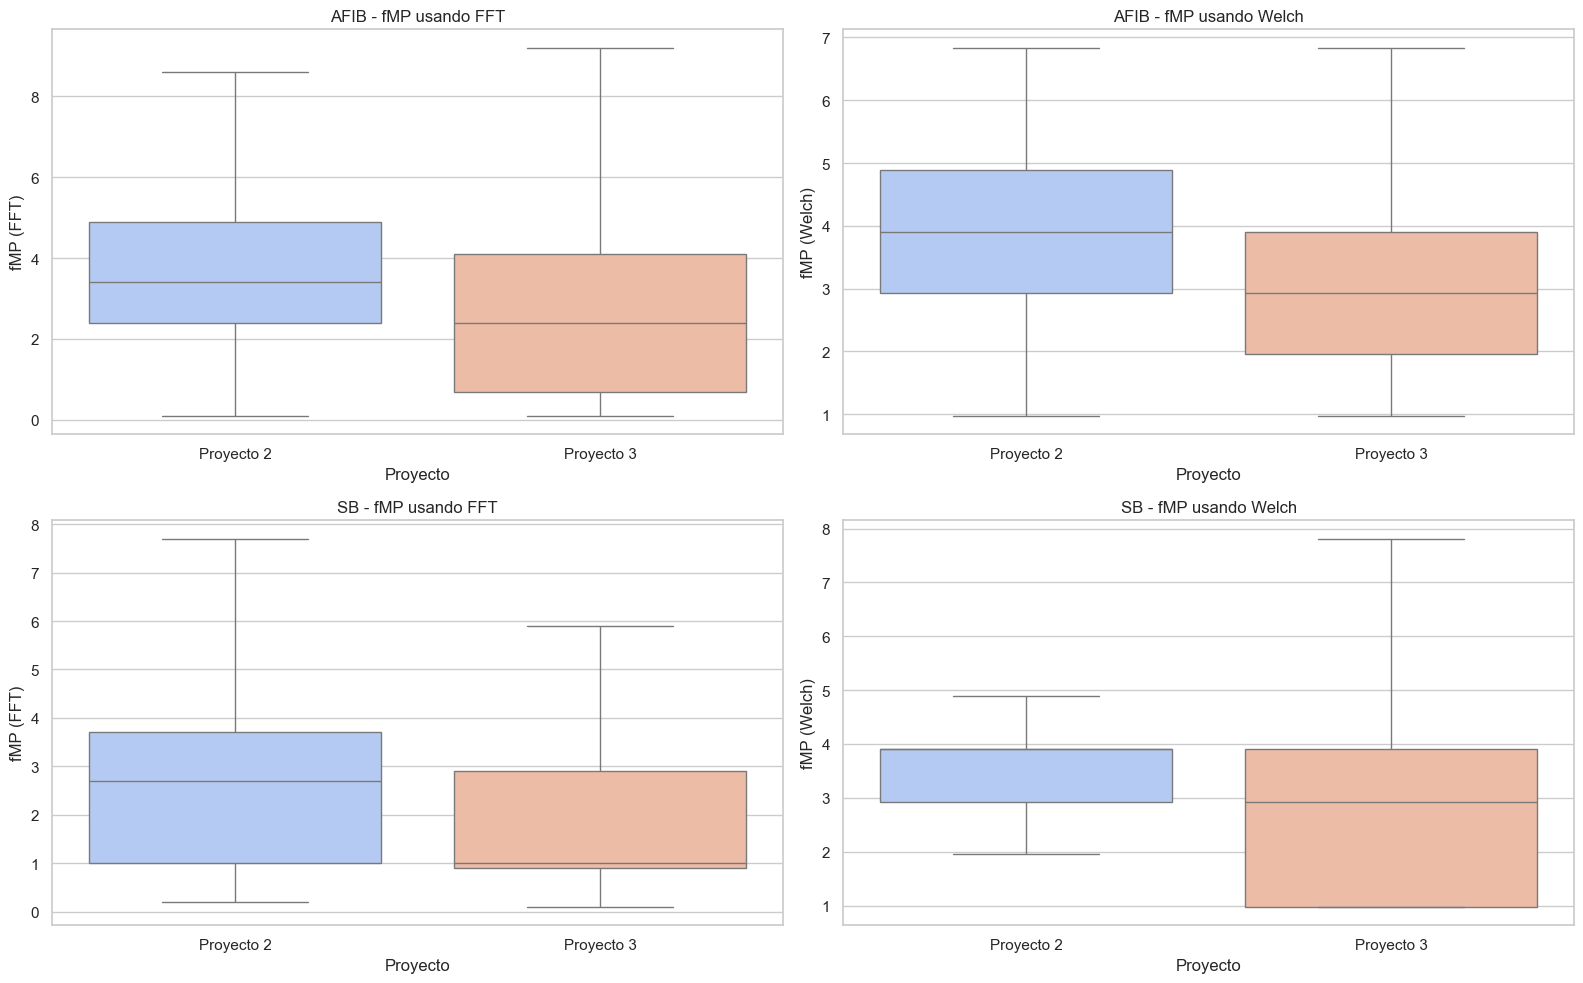

In [115]:
# Crear las etiquetas de proyecto
df_2['Proyecto'] = 'Proyecto 2'
df_fmp['Proyecto'] = 'Proyecto 3'

# Concatenar los DataFrames
data_concatenada = pd.concat([df_2, df_fmp])

# Crear la figura y los subgráficos
plt.figure(figsize=(16, 10))

# Boxplot para AFIB FFT en Proyecto 2 vs Proyecto 3
plt.subplot(2, 2, 1)
sns.boxplot(x='Proyecto', y='fMP(FFT)', data=data_concatenada[data_concatenada['Estado'] == 'AFIB'], palette="coolwarm", showfliers=False)
plt.title('AFIB - fMP usando FFT')
plt.ylabel('fMP (FFT)')
plt.xlabel('Proyecto')

# Boxplot para AFIB Welch en Proyecto 2 vs Proyecto 3
plt.subplot(2, 2, 2)
sns.boxplot(x='Proyecto', y='fMP(Welch)', data=data_concatenada[data_concatenada['Estado'] == 'AFIB'], palette="coolwarm", showfliers=False)
plt.title('AFIB - fMP usando Welch')
plt.ylabel('fMP (Welch)')
plt.xlabel('Proyecto')

# Boxplot para SB FFT en Proyecto 2 vs Proyecto 3
plt.subplot(2, 2, 3)
sns.boxplot(x='Proyecto', y='fMP(FFT)', data=data_concatenada[data_concatenada['Estado'] == 'SB'], palette="coolwarm", showfliers=False)
plt.title('SB - fMP usando FFT')
plt.ylabel('fMP (FFT)')
plt.xlabel('Proyecto')

# Boxplot para SB Welch en Proyecto 2 vs Proyecto 3
plt.subplot(2, 2, 4)
sns.boxplot(x='Proyecto', y='fMP(Welch)', data=data_concatenada[data_concatenada['Estado'] == 'SB'], palette="coolwarm", showfliers=False)
plt.title('SB - fMP usando Welch')
plt.ylabel('fMP (Welch)')
plt.xlabel('Proyecto')

# Ajustar el diseño
plt.tight_layout()
plt.show()

In [116]:

df_S2.rename(columns={'Desviación': 'Desviacion'}, inplace=True)

metrics = ['Media', 'Mediana', 'Desviacion']  # Asegúrate de que estas columnas existan en df_S2 y df_S3

# Inicializa una lista para almacenar los resultados
results = []

# Realiza la prueba para cada métrica y estado
for metric in metrics:
    for estado in ['AFIB', 'SB']:
        # Filtrar los datos por proyecto y estado
        data_proyecto2 = df_S2[df_S2['Estado'] == estado][metric].dropna()
        data_proyecto3 = df_S3[df_S3['Estado'] == estado][metric].dropna()

        # Prueba U de Mann-Whitney
        u_statistic, p_value_mann_whitney = stats.mannwhitneyu(data_proyecto2, data_proyecto3, alternative='two-sided')

        # Determinar si hay una diferencia significativa
        significance = 'Hay Diferencia Significativa' if p_value_mann_whitney <= 0.05 else 'No hay diferencia significativa'

        # Agrega los resultados a la lista
        results.append({
            'Estado': estado,
            'Metric': metric,
            'Mann-Whitney U Statistic': u_statistic,
            'Mann-Whitney p-value': p_value_mann_whitney,
            'Significancia': significance
        })

# Crea un DataFrame con los resultados
results_df = pd.DataFrame(results)

# Muestra el DataFrame con los resultados de la prueba
results_df


,Estado,Metric,Mann-Whitney U Statistic,Mann-Whitney p-value,Significancia
0,AFIB,Media,1301737.5,3.206797e-20,Hay Diferencia Significativa
1,SB,Media,5771070.0,3.909018e-73,Hay Diferencia Significativa
2,AFIB,Mediana,1297616.0,9.083952e-21,Hay Diferencia Significativa
3,SB,Mediana,5443041.0,1.291151e-101,Hay Diferencia Significativa
4,AFIB,Desviacion,1307523.0,1.828011e-19,Hay Diferencia Significativa
5,SB,Desviacion,5480467.0,3.988340e-98,Hay Diferencia Significativa


In [117]:
# Extraer las columnas correspondientes de los DataFrames de los proyectos
fmp_welch_proyecto2 = resultados_fmp2['fMP(Welch)']
fmp_fft_proyecto2 = resultados_fmp2['fMP(FFT)']

fmp_welch_proyecto3 = resultados_fmp3['fMP(Welch)']
fmp_fft_proyecto3 = resultados_fmp3['fMP(FFT)']

# Calcular el MSE entre fMP(Welch) y fMP(FFT) en cada proyecto
mse_welch = mean_squared_error(fmp_welch_proyecto2, fmp_welch_proyecto3)
mse_fft = mean_squared_error(fmp_fft_proyecto2, fmp_fft_proyecto3)

print(f'Error cuadrático medio entre fMP(Welch) del proyecto 2 y proyecto 3: {mse_welch}')
print(f'Error cuadrático medio entre fMP(FFT) del proyecto 2 y proyecto 3: {mse_fft}')

Error cuadrático medio entre fMP(Welch) del proyecto 2 y proyecto 3: 6.046561043086682
Error cuadrático medio entre fMP(FFT) del proyecto 2 y proyecto 3: 8.126946557602116


<hr>

Visualización de sujetos al azar respecto a las señales del proyecto 2

In [118]:
def graficar_sujeto_(señales_F1, señales_F2, señales_F3, ruta_carpeta, tipo="SB"):
    # Crear la figura con 1 columna y 3 filas (para mostrar los tres flujos)
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    fig.suptitle(f"Señal prefiltrada y procesada - Sujeto 3 ({tipo})", fontsize=16)
    
    # Definir las claves para el Sujeto 1 en cada flujo
    clave_f1 = f'{tipo}_Flujo1_S3'
    clave_f2 = f'{tipo}_Flujo2_S3'
    clave_f3 = f'{tipo}_Flujo3_S3'
    
    # Obtener los datos de cada flujo para el Sujeto 1
    datos_f1 = señales_F1.get(clave_f1)
    datos_f2 = señales_F2.get(clave_f2)
    datos_f3 = señales_F3.get(clave_f3)

    # Función para cargar la señal prefiltrada desde el archivo CSV
    def cargar_prefiltrada(nombre_archivo):
        ruta_archivo = f"{ruta_carpeta}/{nombre_archivo}.csv"
        try:
            # Leer el archivo CSV y obtener los datos de la señal
            df = pd.read_csv(ruta_archivo)
            return df.iloc[:, 1].values  # Asumimos que la columna 1 tiene la señal
        except FileNotFoundError:
            print(f"Archivo no encontrado: {ruta_archivo}")
            return None
    
    # Graficar las señales prefiltrada y procesada para cada flujo
    if datos_f1:
        # Cargar la señal prefiltrada
        signal_prefiltrada = cargar_prefiltrada(datos_f1['nombre_archivo'])
        if signal_prefiltrada is not None:
            axes[0].plot(signal_prefiltrada, label="Prefiltrada", color='purple', alpha=0.7)
            axes[0].plot(datos_f1['procesada'], label="Procesada", color='#64B5F6', alpha=0.7)
            axes[0].set_title("Sujeto 3 - Flujo 1")
            axes[0].legend(loc="upper right")
            axes[0].set_ylabel("Amplitud")

    if datos_f2:
        # Cargar la señal prefiltrada
        signal_prefiltrada = cargar_prefiltrada(datos_f2['nombre_archivo'])
        if signal_prefiltrada is not None:
            axes[1].plot(signal_prefiltrada, label="Prefiltrada", color='purple', alpha=0.7)
            axes[1].plot(datos_f2['procesada'], label="Procesada", color='#64B5F6', alpha=0.7)
            axes[1].set_title("Sujeto 3 - Flujo 2")
            axes[1].legend(loc="upper right")
            axes[1].set_ylabel("Amplitud")

    if datos_f3:
        # Cargar la señal prefiltrada
        signal_prefiltrada = cargar_prefiltrada(datos_f3['nombre_archivo'])
        if signal_prefiltrada is not None:
            axes[2].plot(signal_prefiltrada, label="Prefiltrada", color='purple', alpha=0.7)
            axes[2].plot(datos_f3['procesada'], label="Procesada", color='#64B5F6', alpha=0.7)
            axes[2].set_title("Sujeto 3 - Flujo 3")
            axes[2].legend(loc="upper right")
            axes[2].set_ylabel("Amplitud")
        
    # Ajustar el layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

ruta_carpeta = r"C:\Users\luisa\Downloads\ECGDataDenoised\ECGDataDenoised"

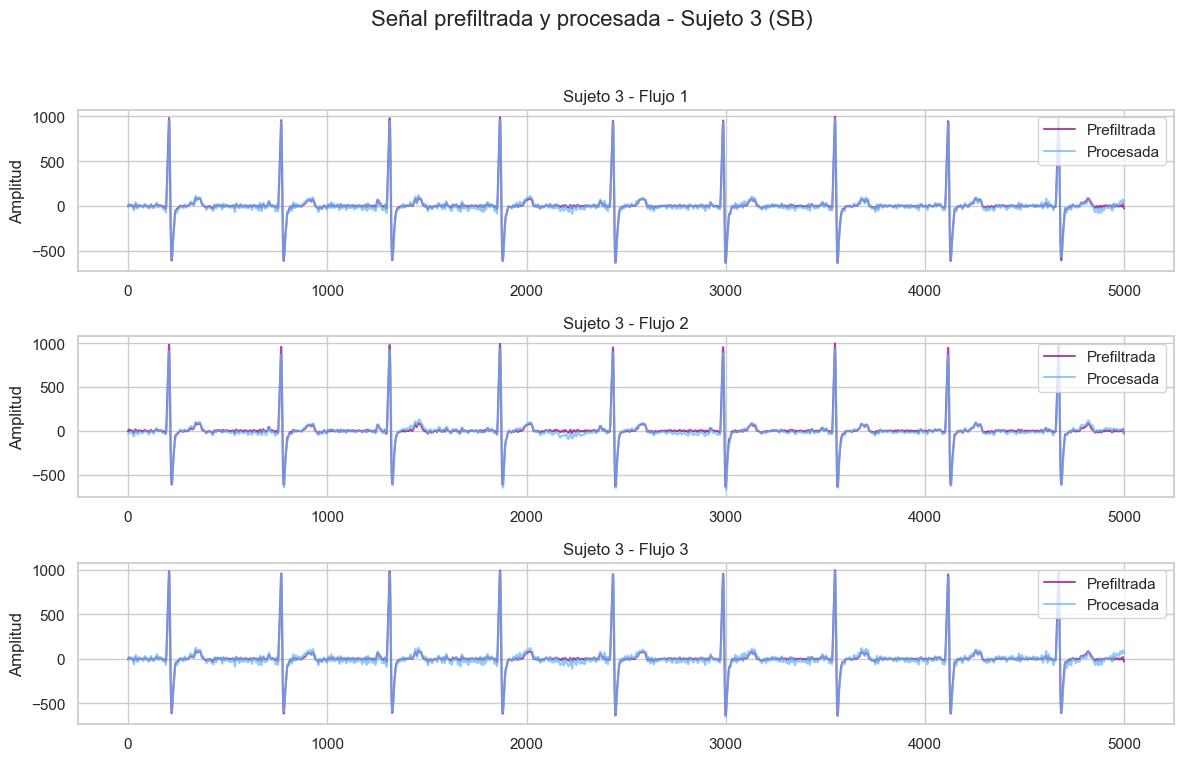

In [119]:
# Llamada a la función para graficar las señales para el sujeto 1 y tipo "SB"
graficar_sujeto_(señales_procesadas_F1_SB, señales_procesadas_F2_SB, señales_procesadas_F3_SB, ruta_carpeta, tipo="SB")

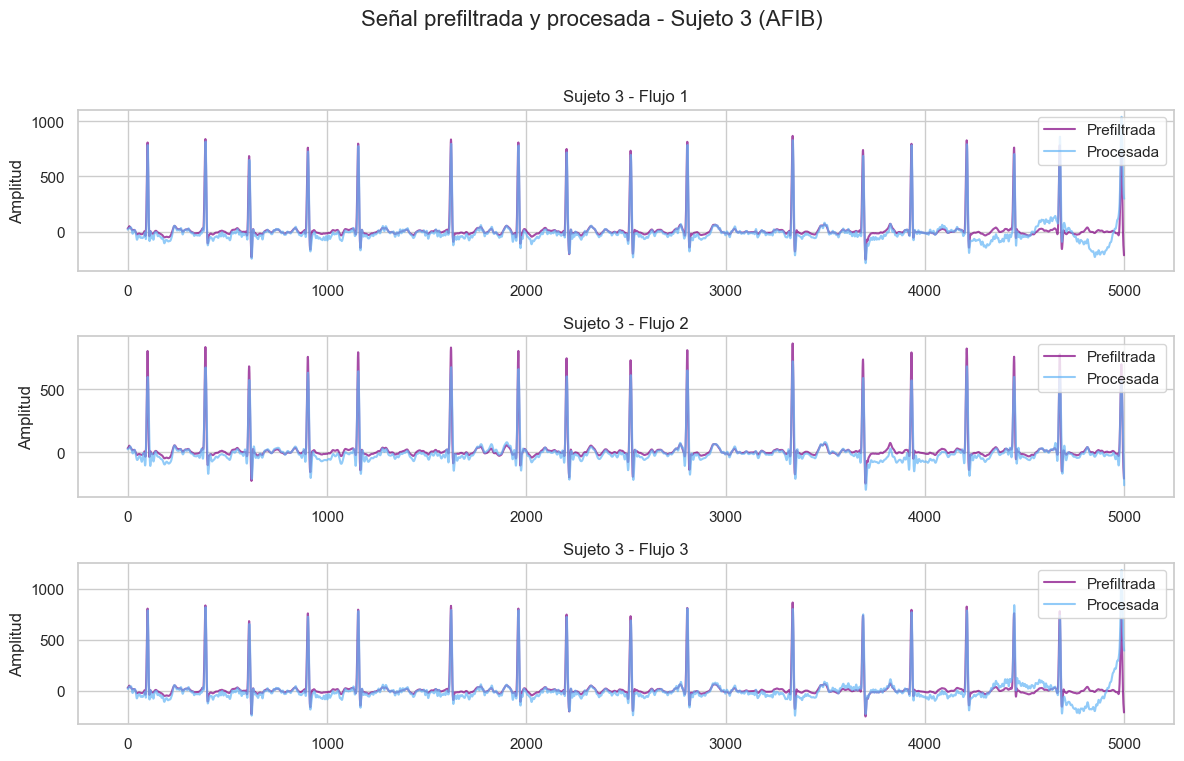

In [120]:
# Llamada a la función para graficar las señales para el sujeto 1 y tipo "SB"
graficar_sujeto_(señales_procesadas_F1_AFIB, señales_procesadas_F2_AFIB, señales_procesadas_F3_AFIB, ruta_carpeta, tipo="AFIB")